# Data Science Workshop

# Data Loading

## Import Python Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

import sklearn.linear_model as lm
from sklearn import metrics, preprocessing, svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

import random

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

## Reading the Income Classification Dataset

In [4]:
# read the entire file into a python array
with open('new_raw_data.json', 'rb') as f:
    data = f.readlines()
with open('photos.json', 'rb') as f:
    photos_data = f.readlines()
with open('not_self_feeds.json', 'rb') as f:
    feeds_data = f.readlines()
with open('self_feeds.json', 'rb') as f:
    posts_data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
photos_data = map(lambda x: x.rstrip(), photos_data)
feeds_data = map(lambda x: x.rstrip(), feeds_data)
posts_data = map(lambda x: x.rstrip(), posts_data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"
photos_data_json_str = "[" + ','.join(photos_data) + "]"
feeds_data_json_str = "[" + ','.join(feeds_data) + "]"
posts_data_json_str = "[" + ','.join(posts_data) + "]"

# now, load it into pandas
raw_data = pd.read_json(data_json_str)
photos_raw_data = pd.read_json(photos_data_json_str)
feeds_raw_data = pd.read_json(feeds_data_json_str)
posts_raw_data = pd.read_json(posts_data_json_str)

# join all data frames - used inner join to get rid of outdated pages (pages that got deleted between our queries)
raw_data = pd.merge(left=raw_data, right=photos_raw_data, how='inner', left_on='id', right_on='page_id')
raw_data = pd.merge(left=raw_data, right=posts_raw_data, how='inner', left_on='id', right_on='page_id')
# most pages didnt have any posts from other users/pages on their feed, so left join is used here
raw_data = pd.merge(left=raw_data, right=feeds_raw_data, how='left', left_on='id', right_on='page_id')

raw_data.drop(['page_id_x', 'page_id_y', 'page_id'], axis=1, inplace=True)

In [12]:
# read the entire file into a python array
# with open('feeds.json', 'rb') as f:
#     data = f.readlines()
# data = map(lambda x: x.rstrip(), data)
# data_json_str = "[" + ','.join(data) + "]"
# raw_data = pd.read_json(data_json_str)


# Data preparation

In [5]:
ready_feats = [ 'has_cover_photo', 'has_profile_photo', 'id', 'likes', 'has_bio', 'has_birthday', 'has_company_overview',
                'has_about', 'has_hours', 'checkins', 'has_payment_options', 'search_category', 'has_mission', 'category',
#                 'category_list_len'
               
                # photo fields
                'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 'photo_avg_likes_per_photo',
                'photo_avg_people_tagged_per_photo', 'photo_avg_people_tagged_per_photo_with_more_than_zero', 
                'photo_count_has_name', 'photo_count_has_place', 'photo_distinct_uploaders', 
                'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 'photo_number_of_albums', 
                'photo_number_of_cover_albums', 'photo_number_of_different_months_for_photos', 'photo_number_of_null_albums', 
                'photo_number_of_other_albums', 'photo_number_of_photos_in_cover_albums', 'photo_number_of_photos_in_null_albums', 
                'photo_number_of_photos_in_other_albums', 'photo_number_of_photos_in_profile_albums', 
                'photo_number_of_profile_albums', 'total_photos', 'photo_number_of_days_between_first_and_last_photos',
               
                # feed fields
                'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 'feed_avg_people_tagged_per_post', 
                'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_number_of_days_between_first_and_last_posts',
                'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_count_has_place', 
                'feed_count_post_updated', 'feed_is_published_count', 'feed_max_comments', 
                'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_number_of_added_photos_category', 
                'feed_number_of_different_months_for_post', 'feed_number_of_null_category', 'feed_number_of_other_categories', 
                'feed_number_of_shared_story_category', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
                'feed_post_updated_prc', 'feed_std_comments', 'feed_std_likes', 'feed_sum_people_tagged_count', 
                'feed_sum_with_tagged_count', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares', 'feed_std_shares',
                'feed_distinct_post_writers', 'feed_post_count',

                # posts fields
                'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_likes_per_comment',                           
                'self_feed_avg_people_tagged_per_post', 'self_feed_avg_people_tagged_per_post_with_more_than_zero',  
                'self_feed_number_of_days_between_first_and_last_posts', 'self_feed_avg_with_tagged_per_post',                        
                'self_feed_avg_with_tagged_per_post_with_more_than_zero', 'self_feed_count_has_place',                                 
                'self_feed_count_post_updated', 'self_feed_is_published_count', 'self_feed_max_comments',
                'self_feed_max_likes', 'self_feed_min_comments', 'self_feed_min_likes', 'self_feed_number_of_added_photos_category',                 
                'self_feed_number_of_different_months_for_post', 'self_feed_number_of_null_category', 'self_feed_number_of_other_categories',                      
                'self_feed_number_of_shared_story_category', 'self_feed_post_max_people_tagged', 'self_feed_post_max_with_tagged',                            
                'self_feed_post_updated_prc', 'self_feed_std_comments', 'self_feed_std_likes', 'self_feed_sum_people_tagged_count',                         
                'self_feed_sum_with_tagged_count', 'self_feed_avg_shares', 'self_feed_max_shares', 'self_feed_min_shares',                                      
                'self_feed_std_shares', 'self_post_count'
              ]

all_data = raw_data[ready_feats].copy()

# merge identical columns
all_data['general_info'] = pd.concat([raw_data['generalInfo'].dropna(), raw_data['general_info'].dropna()]).reindex_like(raw_data)
all_data['is_permanently_closed'] = pd.concat([raw_data['isPermanentlyClosed'].dropna(), raw_data['is_permanently_closed'].dropna()]).reindex_like(raw_data)
all_data['is_unclaimed'] = pd.concat([raw_data['isUnclaimed'].dropna(), raw_data['is_unclaimed'].dropna()]).reindex_like(raw_data)
all_data['is_verified'] = pd.concat([raw_data['isVerified'].dropna(), raw_data['is_verified'].dropna()]).reindex_like(raw_data)
all_data['price_range'] = pd.concat([raw_data['priceRange'].dropna(), raw_data['price_range'].dropna()]).reindex_like(raw_data)
all_data['start_info'] = pd.concat([raw_data['startInfo'].dropna(), raw_data['start_info'].dropna()]).reindex_like(raw_data)
all_data['talking_about_count'] = pd.concat([raw_data['talkingAboutCount'].dropna(), raw_data['talking_about_count'].dropna()]).reindex_like(raw_data)
all_data['were_here_count'] = pd.concat([raw_data['wereHereCount'].dropna(), raw_data['were_here_count'].dropna()]).reindex_like(raw_data)

# create 'has' columns
all_data['has_email'] = raw_data['emails'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_phone'] = raw_data['phone'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_website'] = raw_data['website'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_location'] = raw_data['location'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_description'] = raw_data['description'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_general_info'] = all_data['general_info'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_products'] = raw_data['products'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['self_feed_has_unpublished'] = all_data[['self_post_count','self_feed_is_published_count']].apply(lambda x: x['self_post_count'] == x['self_feed_is_published_count'], 1)

# create 'num of words' columns
all_data['name_num_of_words'] = raw_data['name'].apply(lambda x: len(x.split()) if type(x) != np.float else np.nan)

# parse complex vars
all_data['location_city'] = raw_data['location'].apply(lambda x: x['city'] if (type(x) != np.float and 'city' in x) else np.nan)
all_data['location_city'].fillna(raw_data['hometown'], inplace=True)
all_data['location_country'] = raw_data['location'].apply(lambda x: x['country'] if (type(x) != np.float and 'country' in x) else np.nan)
all_data['start_info'] = all_data['start_info'].apply(lambda x: x['date']['year'] if (type(x) != np.float and 'date' in x and 'year' in x['date']) else np.nan)
all_data['price_range'] = all_data['price_range'].apply(lambda x: len(x) if type(x) != np.float else np.nan)

category_mapping = {'Bank': 'business', 'Bar': 'life_style', 'Beauty': 'life_style', 'Beverages': 'food', 'Book': 'entertainment', 'Business': 'business', 'Character': 'entertainment', 'Church': 'organization', 'Coffee': 'life_style', 'Company': 'business', 'Equipment': 'industrial', 'Event': 'organization', 'Financial': 'business', 'Foo': 'food', 'Food': 'food', 'Goods': 'life_style', 'Government': 'organization', 'Health': 'life_style', 'Materials': 'industrial', 'Movie': 'entertainment', 'Music': 'entertainment', 'Organization': 'organization', 'Pet': 'life_style', 'Political': 'organization', 'Public': 'organization', 'School': 'organization', 'Services': 'business', 'Sports': 'entertainment', 'Supplies': 'industrial', 'TV': 'entertainment', 'Team': 'entertainment', 'Venue': 'organization', 'Video': 'entertainment'}        
all_data['main_category'] = all_data['search_category'].map(category_mapping)

# frequency related features - move to feature eng
all_data['photo_upload_freq'] = all_data.apply(lambda x: x['photo_number_of_days_between_first_and_last_photos']/x['total_photos'] if x['photo_number_of_days_between_first_and_last_photos'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
all_data['feed_update_freq'] = all_data.apply(lambda x: x['feed_number_of_days_between_first_and_last_posts']/x['feed_post_count'] if x['feed_number_of_days_between_first_and_last_posts'] != np.nan and x['feed_post_count'] != np.nan else 0, axis=1)
all_data['posting_freq'] = all_data.apply(lambda x: x['self_feed_number_of_days_between_first_and_last_posts']/x['self_post_count'] if x['self_feed_number_of_days_between_first_and_last_posts'] != np.nan and x['self_post_count'] != np.nan else 0, axis=1)

# convert types
all_data['founded'] = raw_data['founded'].apply(lambda x: np.int64(x) if (type(x) == unicode and x.strip().isdigit()) else np.nan)

# drop duplicate pages (we got some pages twice because we queried by page category and some pages were in several categrories)
all_data.drop_duplicates(subset='id', keep='last', inplace=True)

## Missing Data Imputation

In [6]:
print "Missing data by column (total rows %s):" % all_data.id.count()
missing_count = all_data.isnull().sum().sort_values(ascending=False)
print missing_count[missing_count.nonzero()[0]]

Missing data by column (total rows 12773):
feed_avg_with_tagged_per_post_with_more_than_zero           12505
feed_avg_people_tagged_per_post_with_more_than_zero         12031
feed_std_shares                                             11708
general_info                                                11504
self_feed_avg_with_tagged_per_post_with_more_than_zero      10936
founded                                                     10892
feed_avg_shares                                             10603
feed_max_shares                                             10603
feed_min_shares                                             10603
price_range                                                  9660
feed_avg_people_tagged_per_post                              8470
feed_number_of_days_between_first_and_last_posts             8470
feed_avg_with_tagged_per_post                                8470
feed_post_max_people_tagged                                  8470
feed_post_max_with_tagged        

In [7]:
# drop features too sparse or that have no meaningful way to fill
feats_to_drop = ['founded', 'start_info', 'general_info', 'feed_avg_with_tagged_per_post_with_more_than_zero', 
                 'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_std_shares', 
                 'self_feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_post_updated_prc']
all_data.drop(feats_to_drop, axis = 1, inplace=True)

# NaN to 0
numeric_impute = [  'photo_avg_people_tagged_per_photo_with_more_than_zero', 'price_range',
                  
                    'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 'feed_avg_people_tagged_per_post', 
                    'feed_number_of_days_between_first_and_last_posts',
                    'feed_avg_with_tagged_per_post', 'feed_count_has_place', 
                    'feed_count_post_updated', 'feed_is_published_count', 'feed_max_comments', 
                    'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_number_of_added_photos_category', 
                    'feed_number_of_different_months_for_post', 'feed_number_of_null_category', 'feed_number_of_other_categories', 
                    'feed_number_of_shared_story_category', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
                    'feed_std_comments', 'feed_std_likes', 
                    'feed_sum_with_tagged_count', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares',
                    'feed_distinct_post_writers', 'feed_post_count', 'feed_update_freq', 'feed_sum_people_tagged_count',
                    
                    'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_people_tagged_per_post', 
                    'self_feed_avg_people_tagged_per_post_with_more_than_zero', 'self_feed_number_of_days_between_first_and_last_posts', 
                    'self_feed_avg_with_tagged_per_post', 'self_feed_max_comments', 
                    'self_feed_max_likes', 'self_feed_min_comments', 'self_feed_min_likes', 'self_feed_post_max_people_tagged', 
                    'self_feed_post_max_with_tagged', 'self_feed_std_comments', 'self_feed_std_likes',  
                    'self_feed_avg_shares', 'self_feed_max_shares', 'self_feed_min_shares', 
                    'self_feed_std_shares', 'posting_freq', 'self_feed_sum_people_tagged_count', 'self_feed_sum_with_tagged_count'
                 ]
all_data[numeric_impute] = all_data[numeric_impute].fillna(0) 

# fill missing countries by city
all_data['location_country'].fillna('empty', inplace=True)
all_data['location_city'].fillna('empty', inplace=True)
temp = {k: g["location_country"].tolist() for k,g in all_data.groupby("location_city")}
city_to_country = {}
for city, countries in temp.items():
    if city == 'empty':
        city_to_country[city] = 'empty'
        continue
    for country in countries:
        if country != 'empty':
            city_to_country[city] = country
            break
    if city_to_country.get(city) is None:
        city_to_country[city] = 'empty'
all_data['location_country'] = all_data.apply(lambda x: x['location_country'] if x['location_country'] != 'empty' else city_to_country[x['location_city']], axis=1)
all_data['location_country'].fillna('empty', inplace=True)
val_count = all_data['location_country'].value_counts()
all_data['country'] = all_data.location_country.apply(lambda x: x if val_count[x] > 150 else 'other')
all_data.drop(['location_city', 'location_country'], axis = 1, inplace=True)

continent_mapping = {'United States': 'America', 'Thailand': 'Asia', 'Australia': 'Australia', 'Bangladesh': 'Asia', 'Brazil': 'America', 'Cambodia': 'Asia', 'Egypt': 'Africa', 'India': 'Asia', 'Israel': 'Asia', 'Mexico': 'America', 'Myanmar': 'Africa', 'Pakistan': 'Asia', 'Philippines': 'Asia', 'South Africa': 'Africa', 'United Kingdom': 'Europe', 'Vietnam': 'Asia', 'empty': 'Global', 'other': 'Europe'}
all_data['continent'] = all_data.country.map(continent_mapping)

print "Columns with missing data: ", all_data.isnull().sum().nonzero()[0]

Columns with missing data:  []


## Types Conversion

In [8]:
binary_variables = ['has_email', 'has_phone', 'has_website', 'has_location', 
                    'is_permanently_closed', 'is_unclaimed', 'is_verified', 'has_description', 
                    'has_general_info', 'has_products', 'self_feed_has_unpublished']

for variable in binary_variables:
    all_data[variable] = all_data[variable].astype(int)
    
for feat in all_data.columns.get_values():
    print "%s\t%s\t%s" % (all_data.columns.get_loc(feat), all_data.dtypes[all_data.columns.get_loc(feat)], feat)

0	int64	has_cover_photo
1	int64	has_profile_photo
2	int64	id
3	int64	likes
4	int64	has_bio
5	int64	has_birthday
6	int64	has_company_overview
7	int64	has_about
8	int64	has_hours
9	int64	checkins
10	int64	has_payment_options
11	object	search_category
12	int64	has_mission
13	object	category
14	float64	photo_avg_comments_per_photo
15	float64	photo_avg_likes_per_comments
16	float64	photo_avg_likes_per_photo
17	float64	photo_avg_people_tagged_per_photo
18	float64	photo_avg_people_tagged_per_photo_with_more_than_zero
19	int64	photo_count_has_name
20	int64	photo_count_has_place
21	int64	photo_distinct_uploaders
22	int64	photo_max_like
23	int64	photo_max_people_tagged
24	int64	photo_min_like
25	int64	photo_number_of_albums
26	int64	photo_number_of_cover_albums
27	int64	photo_number_of_different_months_for_photos
28	int64	photo_number_of_null_albums
29	int64	photo_number_of_other_albums
30	int64	photo_number_of_photos_in_cover_albums
31	int64	photo_number_of_photos_in_null_albums
32	int64	photo_

# Data Cleaning

In [9]:
def get_features_to_analyze():
    features = all_data.columns.get_values().tolist()
    features_to_remove = ['likes', 'country', 'search_category', 'category', 'main_category', 'continent']
    return [a for a in features if a not in features_to_remove]

### Remove features with low std

In [10]:
features = get_features_to_analyze()
stds = {}

for feat in features:
    curr_std = all_data[feat].std()
    stds[feat] = curr_std
    
sorted_by_std = sorted(stds.items(), key=lambda x: x[1])
low_std = [a for a in sorted_by_std if a[1] < 0.3]
for a in low_std:
    print a[0] + " -- with std of: " + str(a[1])

photo_number_of_photos_in_null_albums -- with std of: 0.0
has_profile_photo -- with std of: 0.0
photo_number_of_null_albums -- with std of: 0.0
photo_distinct_uploaders -- with std of: 0.0
is_permanently_closed -- with std of: 0.0176942650361
is_unclaimed -- with std of: 0.0197820150598
feed_number_of_null_category -- with std of: 0.0586643438236
has_bio -- with std of: 0.137166483067
feed_avg_people_tagged_per_post -- with std of: 0.150598145682
self_feed_post_updated_prc -- with std of: 0.161076721316
self_feed_has_unpublished -- with std of: 0.16550599025
has_payment_options -- with std of: 0.207863823005
has_about -- with std of: 0.236568340661
has_website -- with std of: 0.279276120539
has_general_info -- with std of: 0.299143338765


In [11]:
zero_std_features = [a[0] for a in sorted_by_std if a[1] == 0]

# remove permanently_closed and is_unclaimed pages
all_data = all_data[all_data['is_permanently_closed'] != 1].reset_index(drop=True)
all_data = all_data[all_data['is_unclaimed'] != 1].reset_index(drop=True)
low_std_features = zero_std_features + ['is_permanently_closed', 'is_unclaimed', 'feed_number_of_null_category']

# drop features with low std
all_data.drop(low_std_features, axis=1, inplace=True)

### Remove too correlated features

In [12]:
features = get_features_to_analyze()

corrs = {}
threshold = 0.9

for i in range(len(features)):
    for j in range(i+1,len(features)):
        curr_corr = np.corrcoef(all_data[features[i]], all_data[features[j]])
        c = curr_corr[0][1]
        if c > threshold or c < -(threshold):
            corrs[(features[i],features[j])] = c
            
sorted_by_corr = sorted(corrs.items(), key=lambda x: x[1], reverse=True)
for a in sorted_by_corr:
        print a[0][0] + " and " + a[0][1] + " -- with correlation of: " + str(a[1])

        

feed_is_published_count and feed_post_count -- with correlation of: 1.0
self_feed_is_published_count and self_post_count -- with correlation of: 0.999902425984
feed_is_published_count and feed_distinct_post_writers -- with correlation of: 0.982135591891
feed_distinct_post_writers and feed_post_count -- with correlation of: 0.982135591891
self_feed_avg_people_tagged_per_post and self_feed_sum_people_tagged_count -- with correlation of: 0.979943565264
feed_max_likes and feed_std_likes -- with correlation of: 0.974911796454
photo_number_of_photos_in_other_albums and total_photos -- with correlation of: 0.97016025273
self_feed_avg_with_tagged_per_post and self_feed_sum_with_tagged_count -- with correlation of: 0.967020046602
photo_number_of_albums and photo_number_of_other_albums -- with correlation of: 0.953475312032
self_feed_max_likes and self_feed_std_likes -- with correlation of: 0.93922959203
feed_post_max_with_tagged and feed_sum_with_tagged_count -- with correlation of: 0.930935953

In [13]:
all_data['self_feed_has_unpublished'] = all_data.apply(lambda x: x['self_post_count'] != x['self_feed_is_published_count'], 1)


# drop features too correlated
too_coor_feats = ['feed_is_published_count', 'self_feed_is_published_count', 'feed_distinct_post_writers',
                  'photo_number_of_photos_in_other_albums', 
                  'self_feed_sum_with_tagged_count', 'self_feed_sum_people_tagged_count',
                  'feed_sum_people_tagged_count', 'feed_sum_with_tagged_count']
all_data.drop(too_coor_feats, axis=1, inplace=True)

# Data Exploration

In [22]:
for feat in all_data.columns.get_values():
    if feat != 'id':
        print "==============================================="
        print all_data[feat].describe()

count   12,764.00
mean         0.19
std          0.39
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_cover_photo, dtype: float64
count        12,764.00
mean        429,905.08
std       2,216,464.40
min               0.00
25%           9,192.25
50%          38,107.50
75%         172,433.25
max     102,762,547.00
Name: likes, dtype: float64
count   12,764.00
mean         0.02
std          0.14
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_bio, dtype: float64
count   12,764.00
mean         0.19
std          0.40
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_birthday, dtype: float64
count   12,764.00
mean         0.12
std          0.33
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_company_overview, dtype: float64
count   12,764.00
mean         0.94
std          0.24
min         

### Likes analysis

count        12,764.00
mean        429,905.08
std       2,216,464.40
min               0.00
25%           9,192.25
50%          38,107.50
75%         172,433.25
max     102,762,547.00
Name: likes, dtype: float64


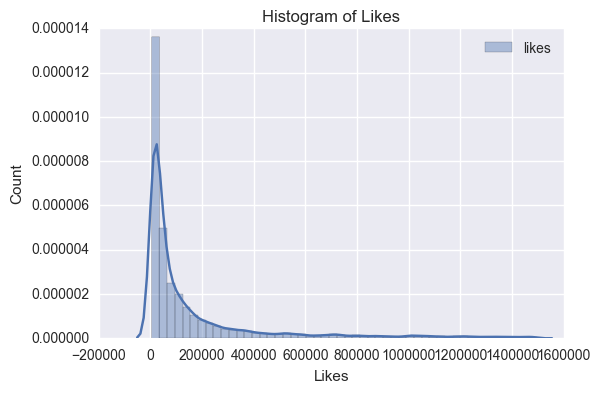

count   12,764.00
mean        10.59
std          2.27
min          0.00
25%          9.13
50%         10.55
75%         12.06
max         18.45
Name: likes, dtype: float64


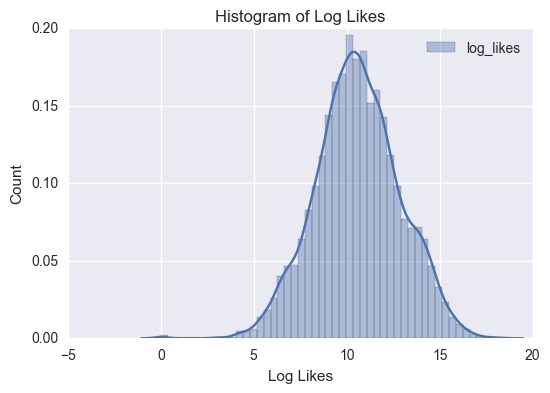

In [17]:
print all_data.likes.describe()
sns.distplot(all_data[(all_data['likes'] > 5000) & (all_data['likes'] < 1500000)].likes, 
             bins = 50, kde = True, label = "likes")
plt.title('Histogram of Likes')
plt.xlabel('Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

log_likes = all_data['likes'].apply(lambda x: np.log(x) if x > 0 else 0)
print log_likes.describe()
sns.distplot(log_likes, bins = 50, kde = True, label = "log_likes")
plt.title('Histogram of Log Likes')
plt.xlabel('Log Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()


In [24]:
avg_likes_per_category = all_data.groupby(['search_category'], as_index=False).mean()[['search_category','likes']].sort_values('likes', ascending=False)
avg_likes_per_category.rename(columns={'likes':'avg_likes'}, inplace=True)
avg_likes_per_category.head(5)

,search_category,avg_likes
19,Movie,"1,618,208.58"
13,Foo,"1,575,577.71"
29,TV,"1,290,613.54"
1,Bar,"1,284,507.66"
3,Beverages,"1,274,734.64"


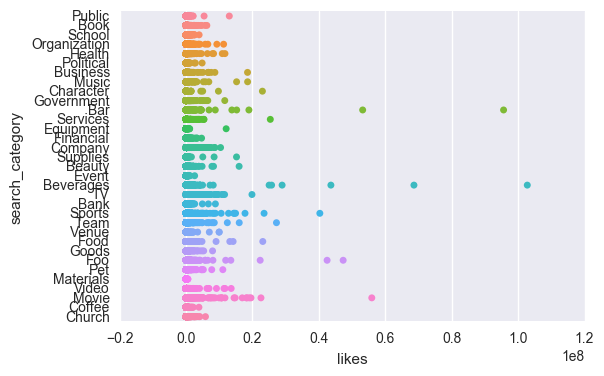

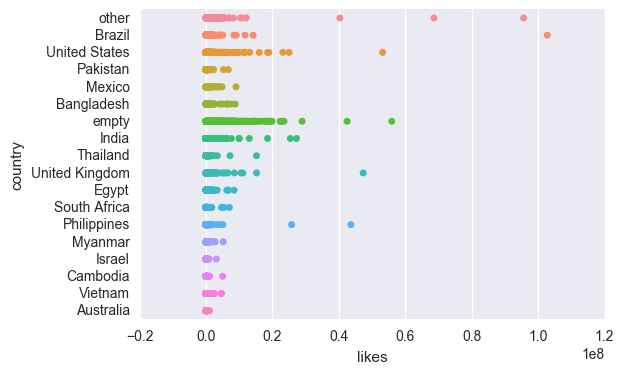

In [12]:
sns.stripplot(x="likes", y="search_category", data=all_data)
plt.show()
sns.stripplot(x="likes", y="country", data=all_data)
plt.show()

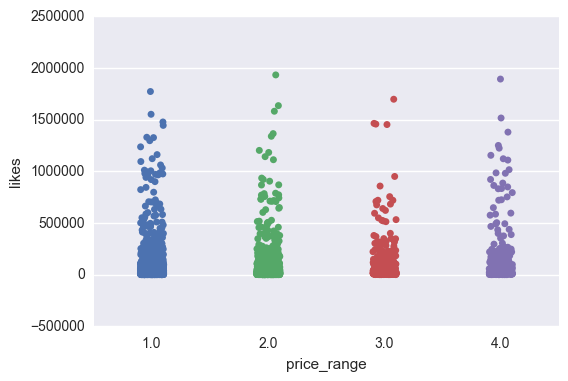

In [26]:
data_to_show = all_data[(all_data['likes'] > 0) & (all_data['likes'] < 2000000)]
price_data = data_to_show[(data_to_show['price_range'] > 0)]
sns.stripplot(x="price_range", y="likes", data=price_data, jitter=True)
plt.show()

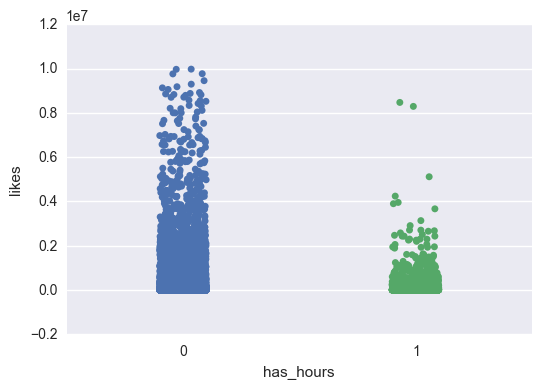

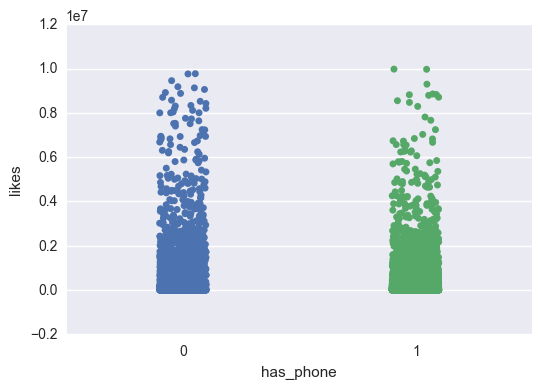

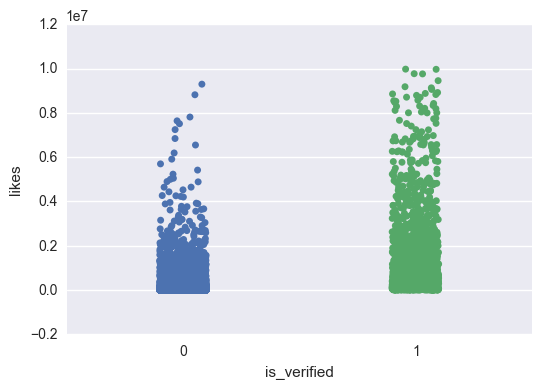

In [27]:
data_to_show = all_data[(all_data['likes'] > 0) & (all_data['likes'] < 10000000)]
sns.stripplot(x="has_hours", y="likes", data=data_to_show, jitter=True)
plt.show()
sns.stripplot(x="has_phone", y="likes", data=data_to_show, jitter=True)
plt.show()
sns.stripplot(x="is_verified", y="likes", data=data_to_show, jitter=True)
plt.show()

# sns.stripplot(x="has_hours", y="likes", data=data_to_show, hue="has_phone", jitter=True)
# plt.show()

In [28]:
def show_numric_features(features):
    for key in features.keys():
        key_dict = features.get(key)
        col = key_dict.get('column')
        data_to_show = all_data[(all_data[col] >= key_dict.get('lower_bound')) & 
                              (all_data[col] <= key_dict.get('upper_bound'))][col]

        sns.distplot(data_to_show, 
                     bins = key_dict.get('bins'), kde = key_dict.get('kde'), label = key)
        plt.title('Histogram of ' + key)
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(loc="upper right")
        plt.show()
        
def show_categorical_features(features):
    for feat in features:
        data_to_show = all_data[[feat]]
        unique_values = data_to_show[feat].unique().tolist()
        unique_values.sort()
        if (unique_values == [0,1]):
            data_to_show = data_to_show.astype(bool)
        sns.plt.title(feat + ' count')
        ax = sns.countplot(feat, data=data_to_show) #,color='purple')
        sns.plt.show()

def show_categorical_data(data):
    for df in data:
        feat = df.columns.tolist()[0]
        ax = sns.countplot(feat, data=df)
        sns.plt.show()

### Genral Info features

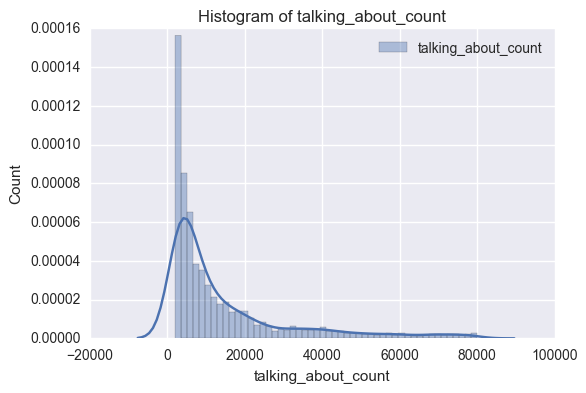

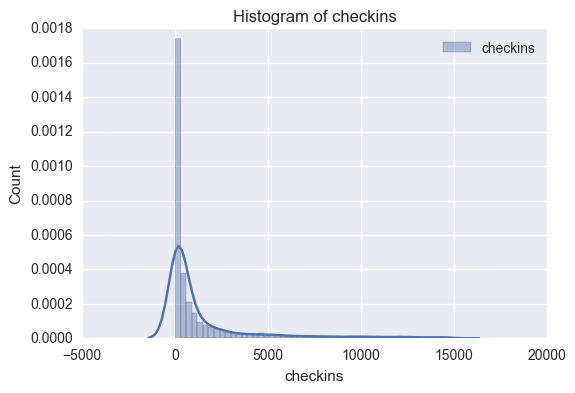

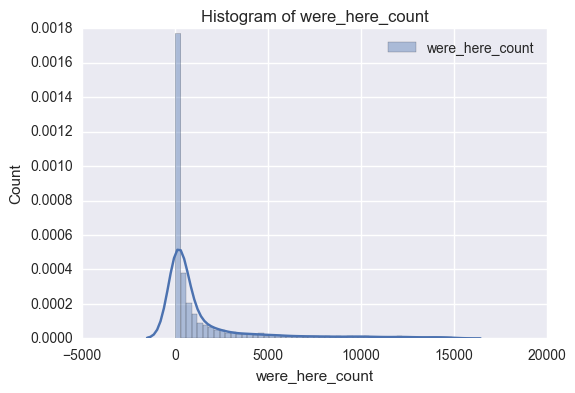

In [29]:
page_numric_features = {'talking_about_count':{'column': 'talking_about_count','lower_bound': 2000, 'upper_bound': 80000, 'bins': 50, 'kde': True},
        'were_here_count':{'column': 'were_here_count','lower_bound': 10, 'upper_bound': 15000, 'bins': 50, 'kde': True},
        'checkins': {'column': 'checkins','lower_bound': 10, 'upper_bound': 15000, 'bins': 50, 'kde': True}}
show_numric_features(page_numric_features)


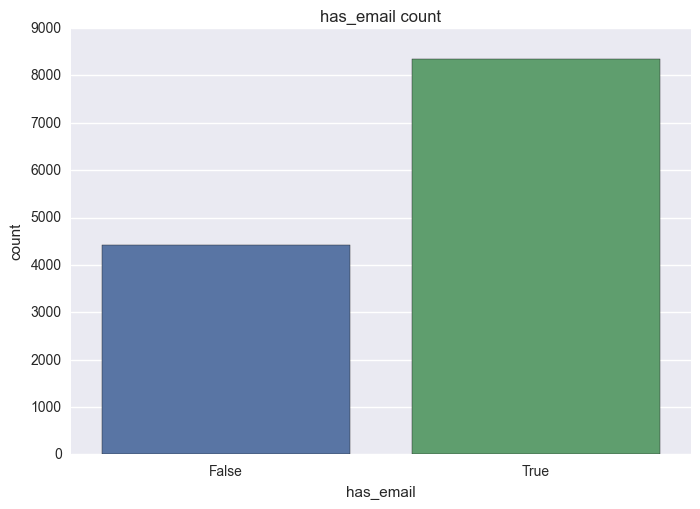

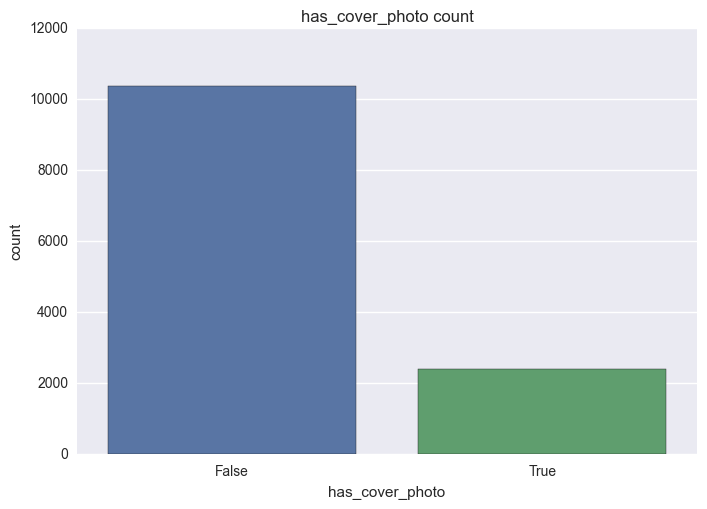

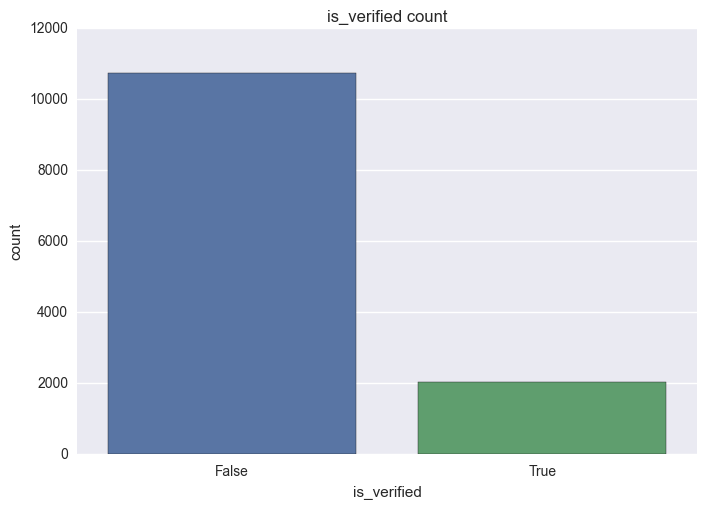

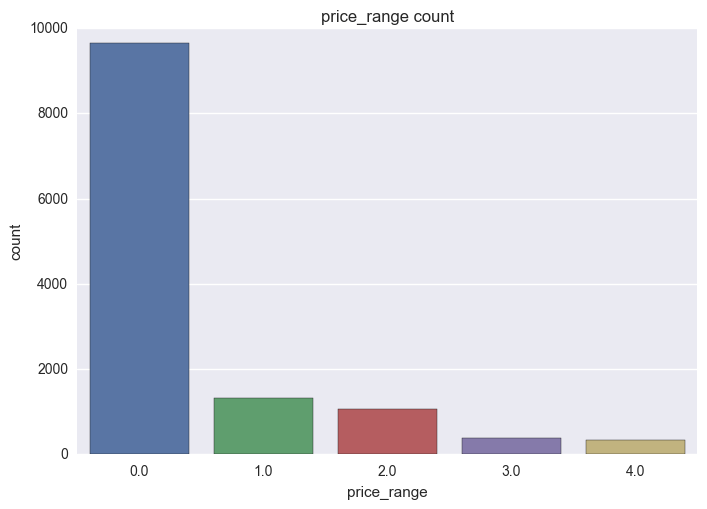

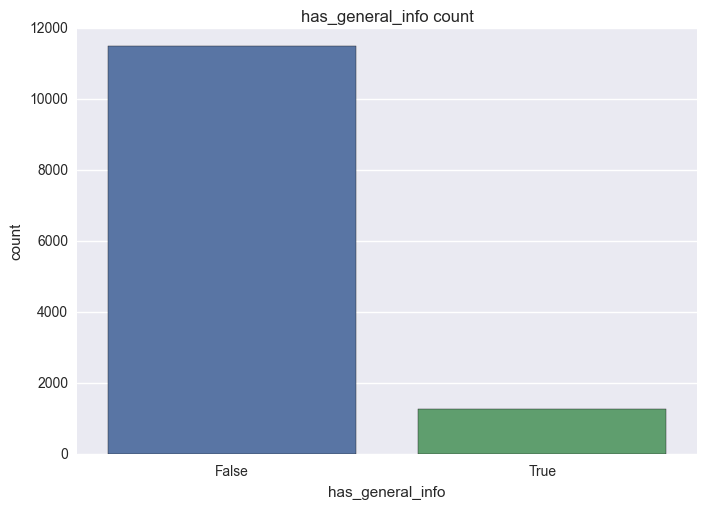

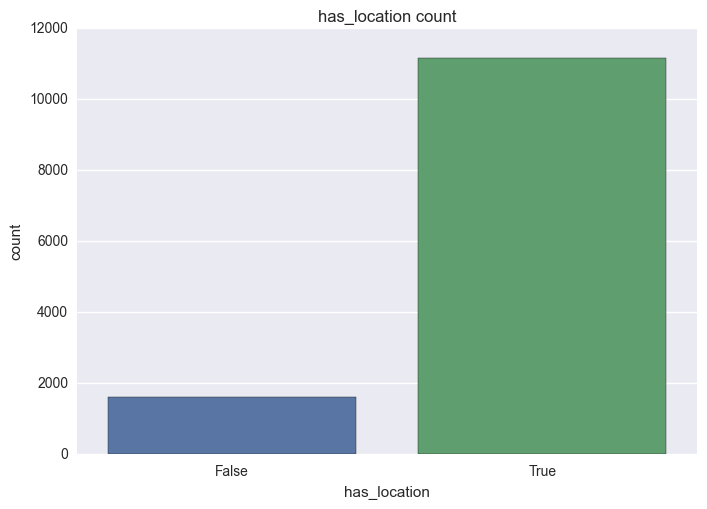

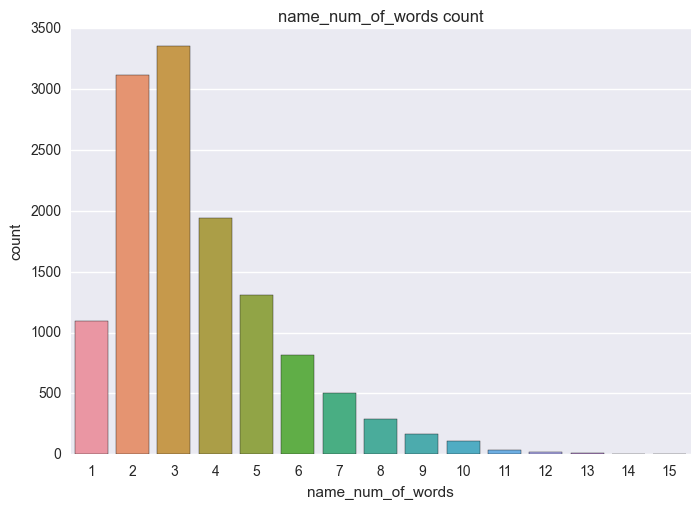

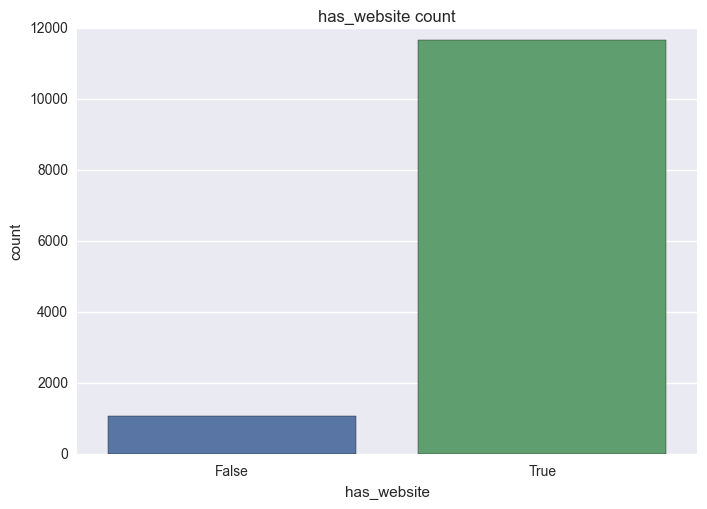

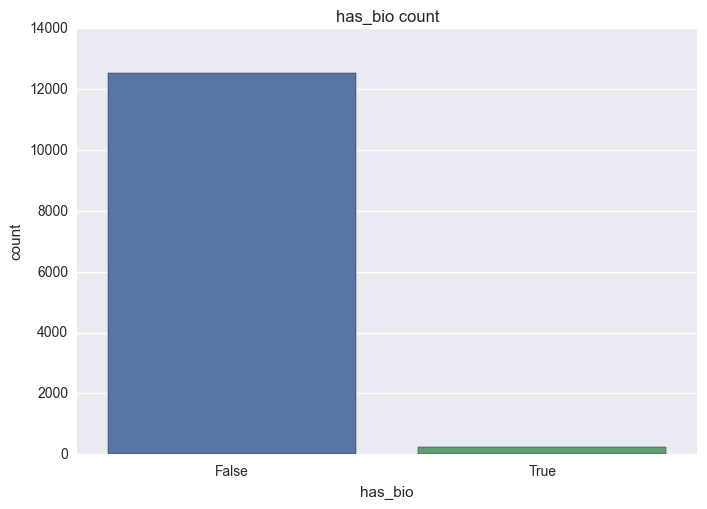

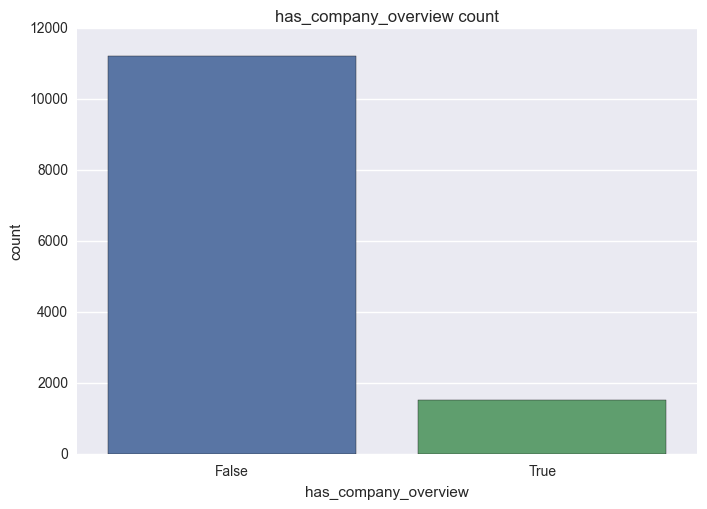

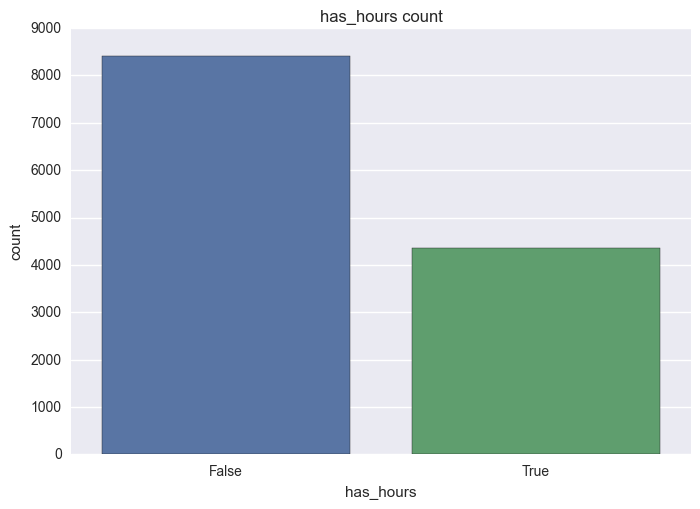

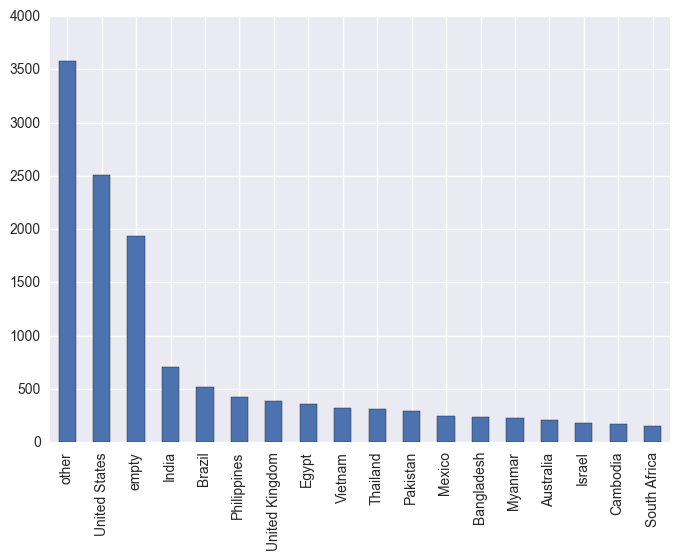

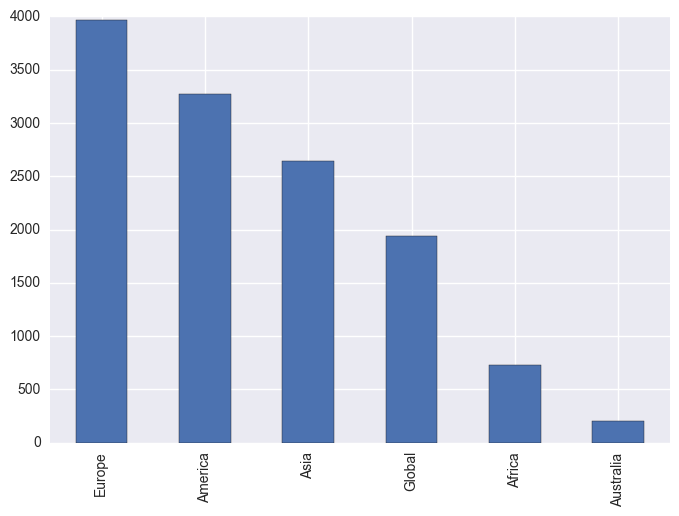

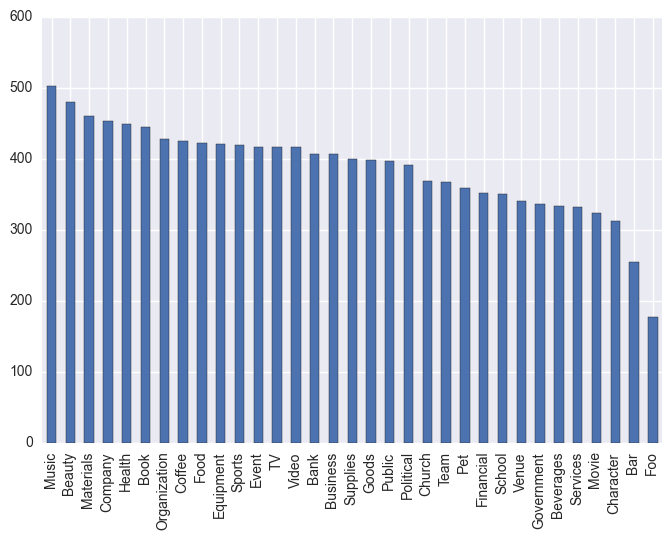

In [46]:
page_categorical_features = ['has_email', 'has_cover_photo', 'is_verified', 'price_range', 
                             'has_general_info', 'has_location', 'name_num_of_words', 'has_website',
                            'has_bio', 'has_company_overview', 'has_hours']

show_categorical_features(page_categorical_features)

# countries count plot
countries = all_data['country'].value_counts().plot(kind='bar')
plt.show()

# continent count plot
continents = all_data['continent'].value_counts().plot(kind='bar')
plt.show()

search_categories = all_data['search_category'].value_counts().plot(kind='bar')
plt.show()


### Self Feed Features

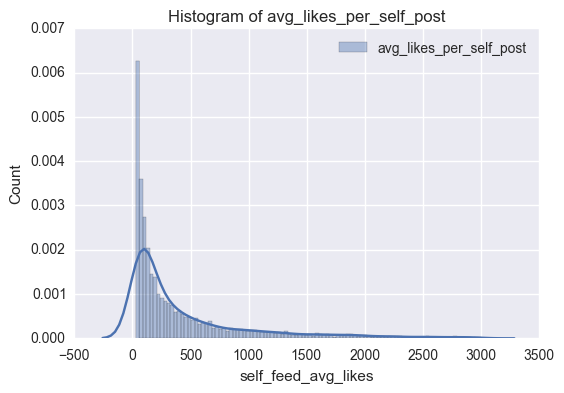

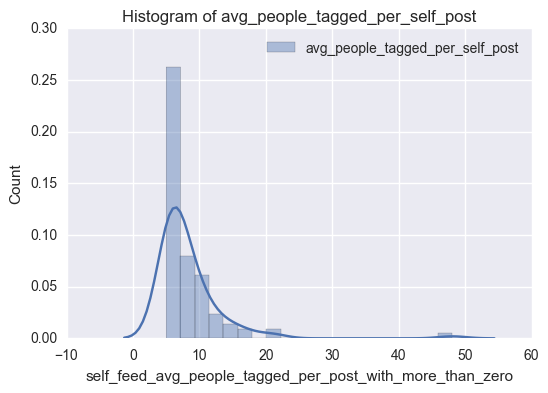

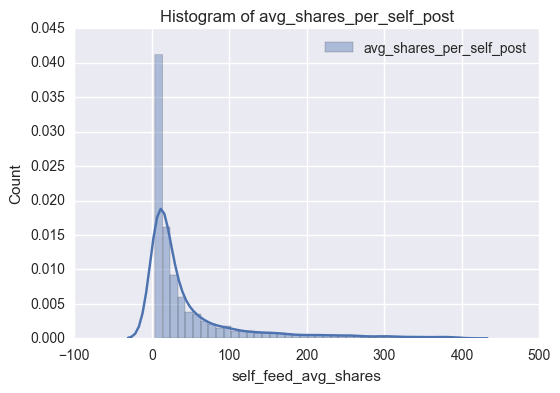

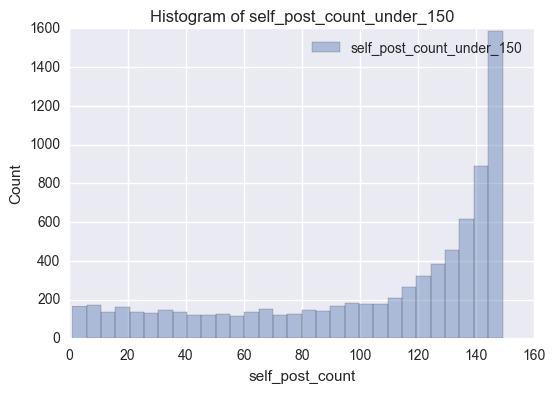

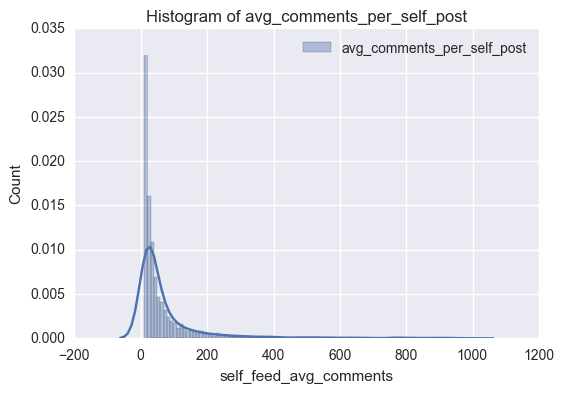

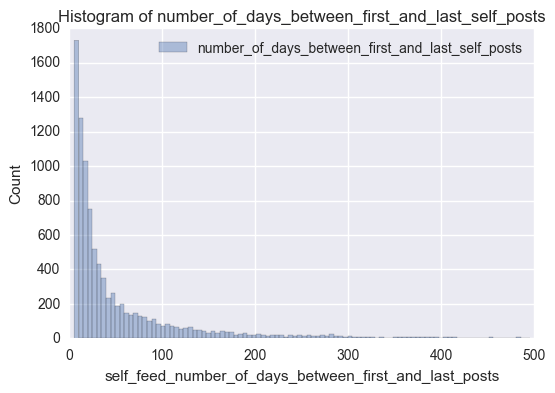

In [31]:
self_feed_numric_features = {'self_post_count_under_150':{'column': 'self_post_count','lower_bound': 0, 'upper_bound': 149, 'bins': 30, 'kde': False},
                        'avg_likes_per_self_post':{'column': 'self_feed_avg_likes','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_comments_per_self_post': {'column': 'self_feed_avg_comments','lower_bound': 10, 'upper_bound': 1000, 'bins': 100, 'kde': True},
                        'avg_shares_per_self_post': {'column': 'self_feed_avg_shares','lower_bound': 4, 'upper_bound': 400, 'bins': 40, 'kde': True},

                        #'max_comments_per_post': {'column': 'feed_max_comments','lower_bound': 50, 'upper_bound': 5000, 'bins': 100, 'kde': True},
                        'avg_people_tagged_per_self_post':{'column': 'self_feed_avg_people_tagged_per_post_with_more_than_zero','lower_bound': 5, 'upper_bound': 100, 'bins': 20, 'kde': True},
                        'number_of_days_between_first_and_last_self_posts': {'column': 'self_feed_number_of_days_between_first_and_last_posts','lower_bound': 5, 'upper_bound': 500, 'bins': 100, 'kde': False}}

show_numric_features(self_feed_numric_features)


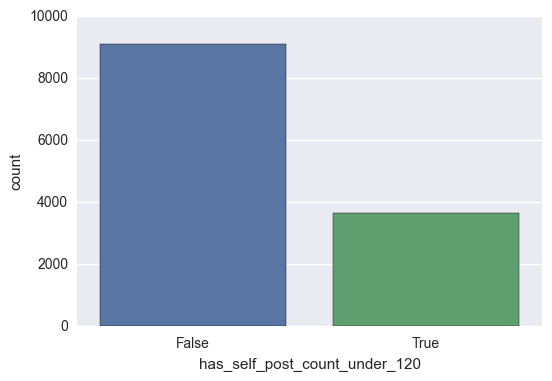

In [32]:
data = [all_data['self_post_count'].apply(lambda x: True if x < 120 else False).to_frame('has_self_post_count_under_120')]
show_categorical_data(data)

### Feed features

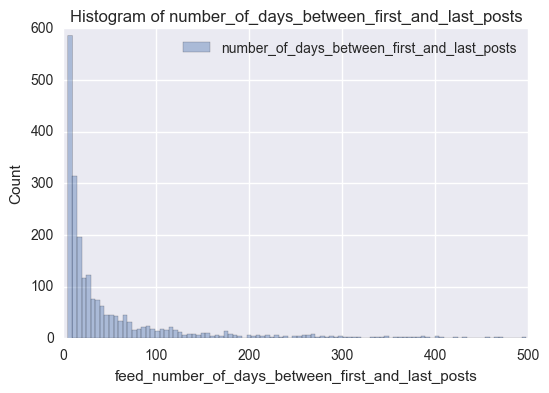

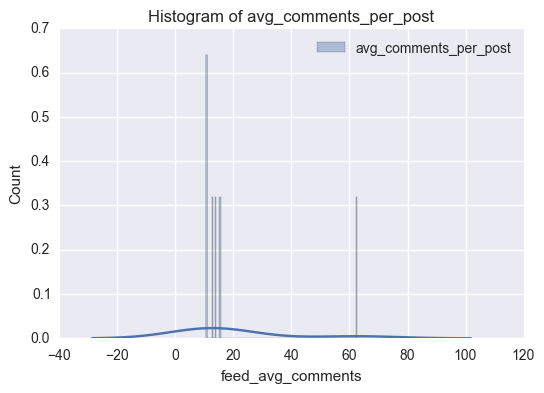

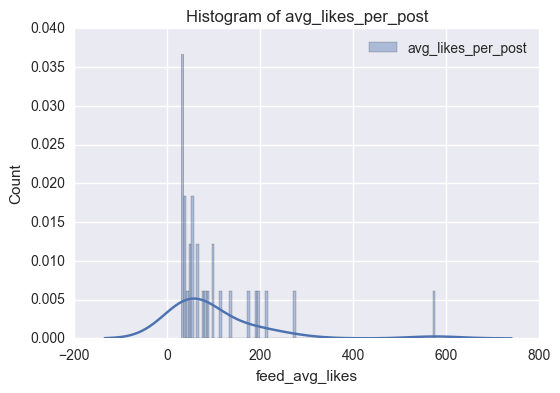

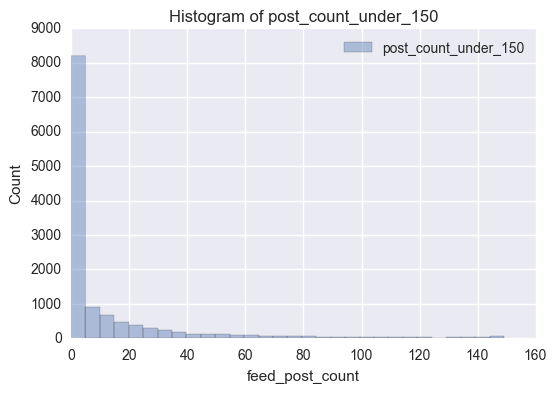

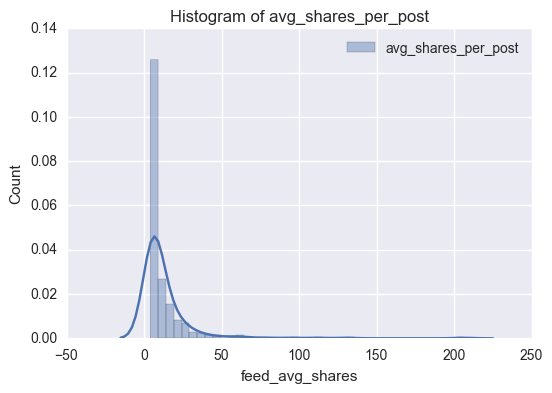

In [33]:
feed_numric_features = {'post_count_under_150':{'column': 'feed_post_count','lower_bound': 0, 'upper_bound': 149, 'bins': 30, 'kde': False},
                        'avg_likes_per_post':{'column': 'feed_avg_likes','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_comments_per_post': {'column': 'feed_avg_comments','lower_bound': 10, 'upper_bound': 1000, 'bins': 100, 'kde': True},
                        'avg_shares_per_post': {'column': 'feed_avg_shares','lower_bound': 4, 'upper_bound': 400, 'bins': 40, 'kde': True},

                        #'max_comments_per_post': {'column': 'feed_max_comments','lower_bound': 50, 'upper_bound': 5000, 'bins': 100, 'kde': True},
                        'number_of_days_between_first_and_last_posts': {'column': 'feed_number_of_days_between_first_and_last_posts','lower_bound': 5, 'upper_bound': 500, 'bins': 100, 'kde': False}}

show_numric_features(feed_numric_features)


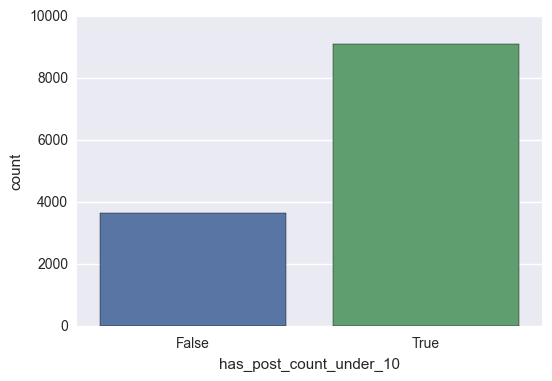

In [34]:
data = [all_data['feed_post_count'].apply(lambda x: True if x < 10 else False).to_frame('has_post_count_under_10')]
show_categorical_data(data)

### Photos features

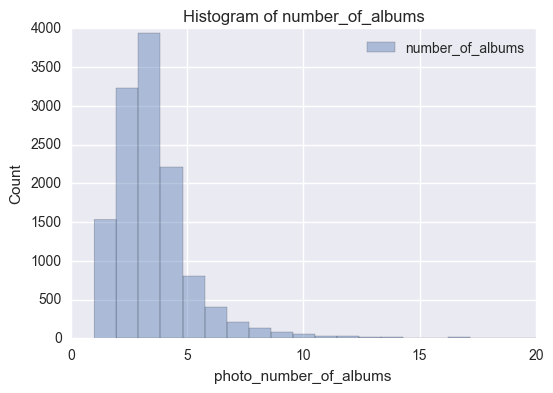

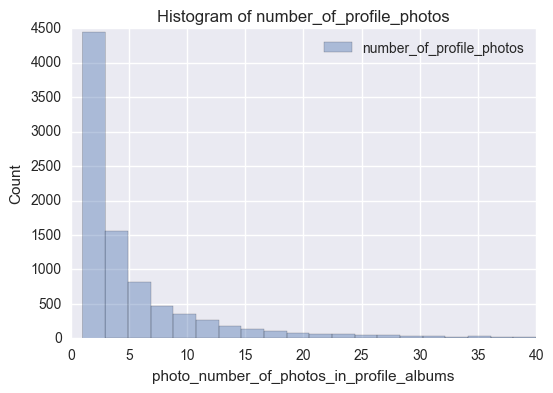

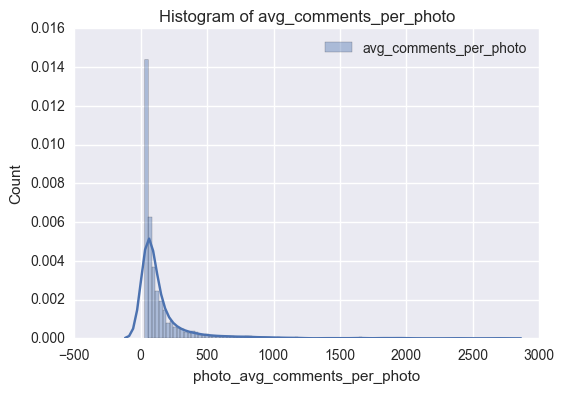

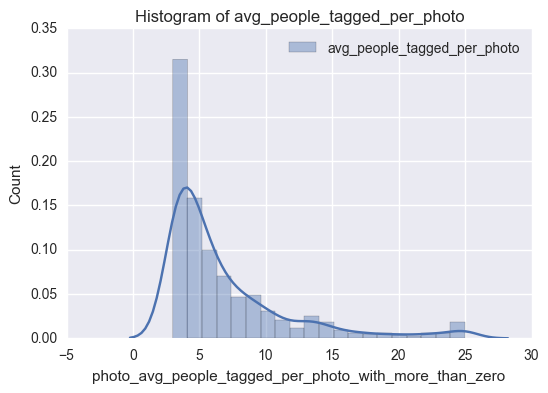

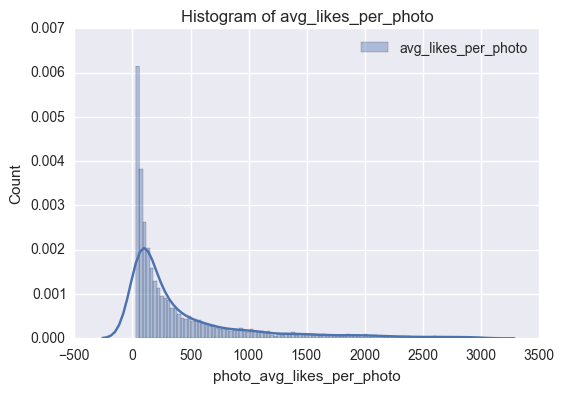

In [35]:
photo_numric_features = {'avg_likes_per_photo':{'column': 'photo_avg_likes_per_photo','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_comments_per_photo':{'column': 'photo_avg_comments_per_photo','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_people_tagged_per_photo':{'column': 'photo_avg_people_tagged_per_photo_with_more_than_zero','lower_bound': 3, 'upper_bound': 100, 'bins': 20, 'kde': True},
                        'number_of_albums': {'column': 'photo_number_of_albums','lower_bound': 0, 'upper_bound': 20, 'bins': 20, 'kde': False},
                        'number_of_profile_photos': {'column':'photo_number_of_photos_in_profile_albums', 'lower_bound': 1, 'upper_bound': 40, 'bins': 20, 'kde': False}}

show_numric_features(photo_numric_features)

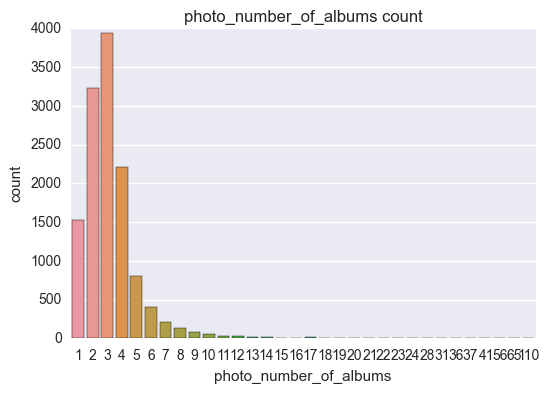

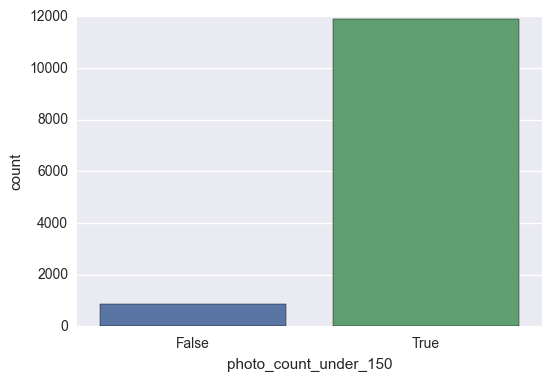

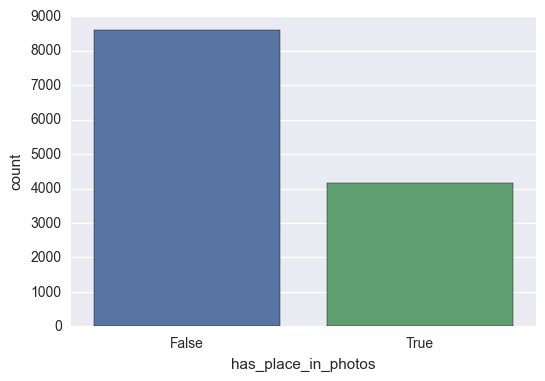

In [36]:
page_categorical_features = ['photo_number_of_albums'] #TODO: add upper bound / move to numrical

show_categorical_features(page_categorical_features)

feat = 'photo_count_under_150'
data = [all_data['total_photos'].apply(lambda x: True if x < 150 else False).to_frame('photo_count_under_150'),
       all_data['photo_count_has_place'].apply(lambda x: True if x > 0 else False).to_frame('has_place_in_photos')]

show_categorical_data(data)
# show_categorical_data(feat, data_to_show)

## Correlations

In [37]:
# detail_variables = ['description_len', 'general_info_len', 'products_len']
# all_data[detail_variables].corr()

In [38]:
def show_correlation(columns):
    data = all_data[columns]
    pd.tools.plotting.scatter_matrix(data, alpha = 0.6, figsize = (10,10), diagonal = 'kde')
    plt.show()

In [39]:
features = get_features_to_analyze()
corrs = {}
for feat in features:
    curr_corr = np.corrcoef(all_data['likes'], all_data[feat])#[1][0]
    corrs[feat] = curr_corr[1][0]

sorted_by_corr = sorted(corrs.items(), key=lambda x: x[1], reverse=True)
i = 1
print("top ten features with the highest correlation to likes count:")
print("=============================================================")
for a in sorted_by_corr[:10]:
    print(str(i) + ') ' + a[0] + ' with correlation of: ' + str(a[1]))
    i += 1


top ten features with the highest correlation to likes count:
1) self_feed_avg_likes with correlation of: 0.516257432373
2) photo_max_like with correlation of: 0.506246959031
3) photo_avg_likes_per_photo with correlation of: 0.498214714981
4) self_feed_std_likes with correlation of: 0.463371163207
5) self_feed_max_likes with correlation of: 0.42325589566
6) photo_avg_comments_per_photo with correlation of: 0.356820406636
7) talking_about_count with correlation of: 0.287140937313
8) is_verified with correlation of: 0.285645268007
9) were_here_count with correlation of: 0.275458465606
10) self_feed_max_comments with correlation of: 0.269848830759


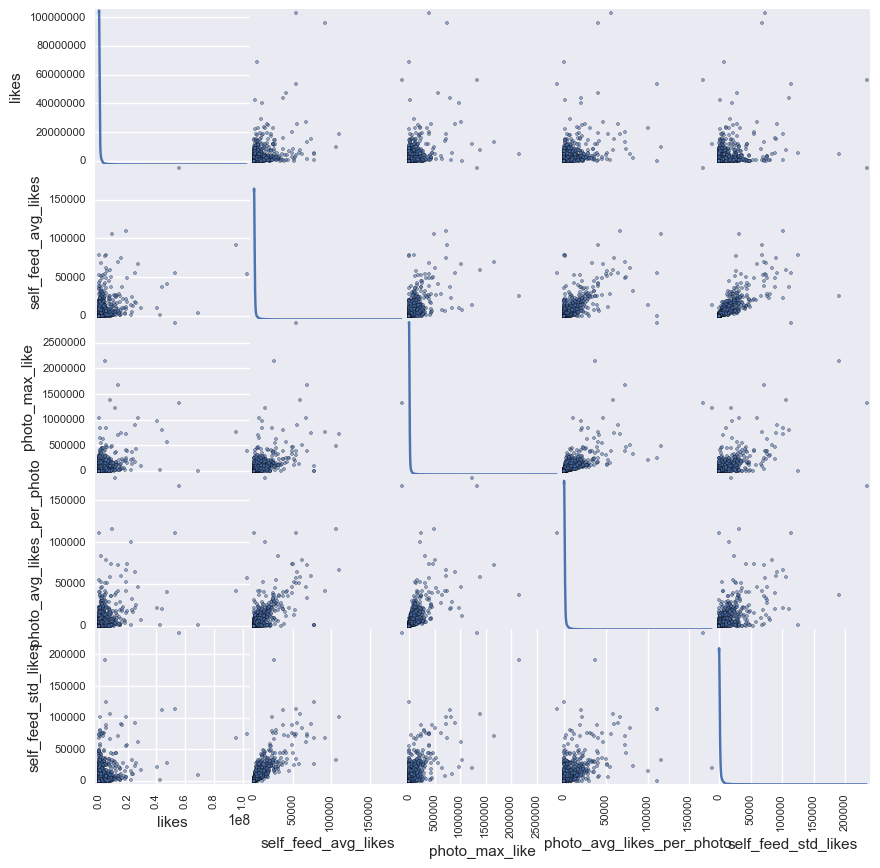

,likes,self_feed_avg_likes,photo_max_like,photo_avg_likes_per_photo,self_feed_std_likes
likes,1.00,0.52,0.51,0.50,0.46
self_feed_avg_likes,0.52,1.00,0.63,0.76,0.85
photo_max_like,0.51,0.63,1.00,0.74,0.73
photo_avg_likes_per_photo,0.50,0.76,0.74,1.00,0.66
self_feed_std_likes,0.46,0.85,0.73,0.66,1.00


In [40]:
corr_features = ['likes'] + [a[0] for a in sorted_by_corr[:4]]
show_correlation(corr_features)
all_data[corr_features].corr()

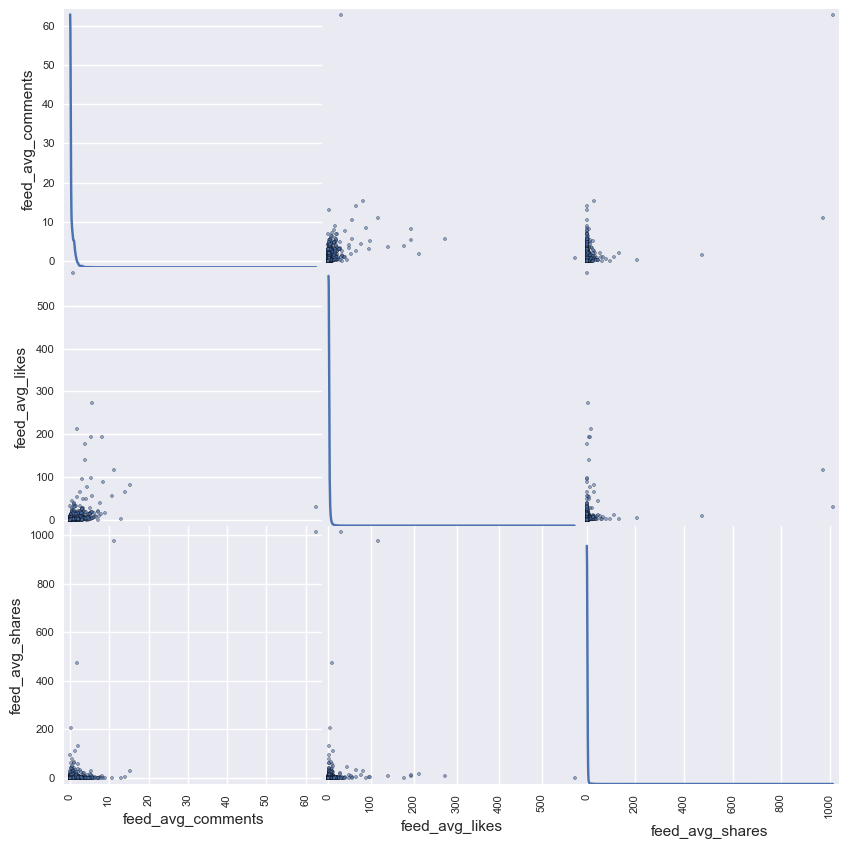

,feed_avg_comments,feed_avg_likes,feed_avg_shares
feed_avg_comments,1.00,0.27,0.51
feed_avg_likes,0.27,1.00,0.14
feed_avg_shares,0.51,0.14,1.00


In [41]:
interaction_variables = ['likes', 'talking_about_count', 'were_here_count'] #'fanCount', 
photo_tags =['photo_avg_people_tagged_per_photo', 'photo_avg_people_tagged_per_photo_with_more_than_zero']
feed_tags = ['feed_avg_with_tagged_per_post', 'feed_avg_people_tagged_per_post']
photo_likes = ['photo_max_like', 'photo_min_like', 'photo_avg_likes_per_photo']
feed_interactions = ['feed_avg_comments', 'feed_avg_likes', 'feed_avg_shares']
feed_categories = ['feed_number_of_added_photos_category','feed_number_of_different_months_for_post',
                   'feed_number_of_null_category', 'feed_number_of_other_categories','feed_number_of_shared_story_category']

show_correlation(feed_interactions)
all_data[feed_interactions].corr()
# show_correlation(photo_likes)
# all_data[feed_tags].corr()

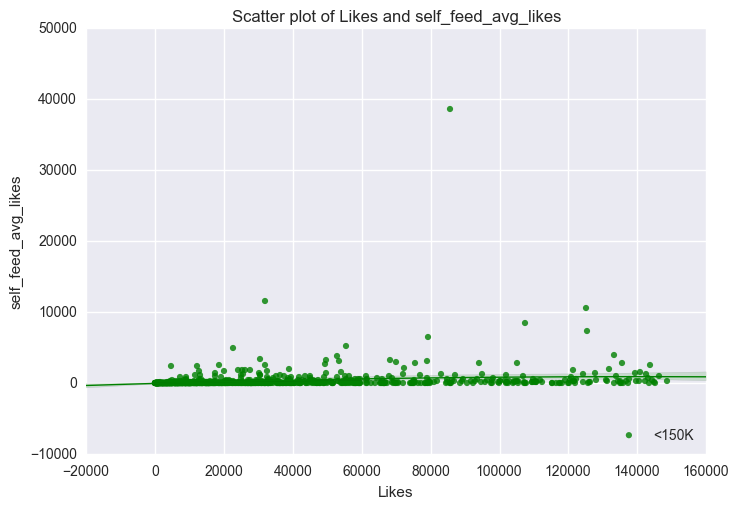

In [42]:
sns.set(color_codes=True)
scatter = pd.DataFrame()
sample = all_data[all_data['likes'] < 150000]
scatter['likes'] = sample['likes']#.apply(lambda x: x/1000)
scatter['self_feed_avg_likes'] = sample['self_feed_avg_likes']#.apply(lambda x: x/1000)
rows = random.sample(scatter.index, 1000)
scatter_10 = scatter.ix[rows]
sns.regplot('likes', 'self_feed_avg_likes', scatter_10, 
            scatter_kws={"marker": ".", "color": "green"},
            line_kws = {"linewidth": "1", "color": "green"},
            order = 2,
            label = '<150K')
plt.xlabel('Likes')
plt.ylabel('self_feed_avg_likes')
plt.legend(loc="lower right")
plt.title("Scatter plot of Likes and self_feed_avg_likes")
plt.show()

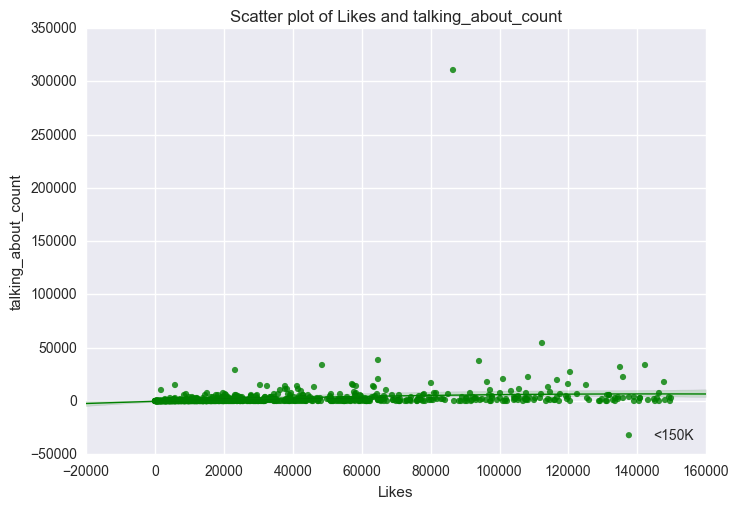

In [43]:
sns.set(color_codes=True)
scatter = pd.DataFrame()
sample = all_data[all_data['likes'] < 150000]
scatter['likes'] = sample['likes']#.apply(lambda x: x/1000)
scatter['talking_about_count'] = sample['talking_about_count']#.apply(lambda x: x/1000)
rows = random.sample(scatter.index, 1000)
scatter_10 = scatter.ix[rows]
sns.regplot('likes', 'talking_about_count', scatter_10, 
            scatter_kws={"marker": ".", "color": "green"},
            line_kws = {"linewidth": "1", "color": "green"},
            order = 2,
            label = '<150K')
plt.xlabel('Likes')
plt.ylabel('talking_about_count')
plt.legend(loc="lower right")
plt.title("Scatter plot of Likes and talking_about_count")
plt.show()

## Manual data normalization

In [44]:
# normal_by_min_max = [   'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 
#                         'photo_avg_likes_per_photo', 'photo_avg_people_tagged_per_photo', 
#                         'photo_avg_people_tagged_per_photo_with_more_than_zero', 'photo_number_of_albums', 
#                         'total_photos', 'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 
                       
#                         'feed_avg_comments', 'feed_avg_likes', 'feed_avg_people_tagged_per_post', 
#                         'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_avg_shares', 
#                         'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_max_comments', 
#                         'feed_max_likes', 'feed_max_shares', 'feed_min_comments',  'feed_min_likes', 'feed_min_shares', 
#                         'feed_post_max_people_tagged', 'feed_post_max_with_tagged',
                     
#                         'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_people_tagged_per_post',
#                         'self_feed_avg_people_tagged_per_post_with_more_than_zero', 'self_feed_avg_shares',
#                         'self_feed_avg_with_tagged_per_post', 'self_feed_avg_with_tagged_per_post_with_more_than_zero',
#                         'self_feed_max_comments', 'self_feed_max_likes', 'self_feed_max_shares', 'self_feed_min_comments',
#                         'self_feed_min_likes', 'self_feed_min_shares', 'self_feed_post_max_people_tagged',
#                         'self_feed_post_max_with_tagged',
#                         'likes']
# temp2 = filtered_all_data.copy()
# tot = 0
# for feat in normal_by_min_max:
#     temp = filtered_all_data[abs(filtered_all_data[feat] - filtered_all_data[feat].mean()) <= 3*filtered_all_data[feat].std()]
#     temp2 = temp2[abs(temp2[feat] - temp2[feat].mean()) <= 3*temp2[feat].std()]
#     tot += filtered_all_data.id.count() - temp.id.count()
#     print "feat: %s, leaves %s samples (%s removed)" % (feat, temp.id.count(), filtered_all_data.id.count() - temp.id.count())

# print tot
# print "final - %s samples left" % temp2.id.count()

# filtered_all_data = temp2.copy()

In [13]:
normal_by_total_count_vars = [  ['photo_number_of_cover_albums', 'photo_number_of_albums'],
                                ['photo_number_of_other_albums', 'photo_number_of_albums'],
                                ['photo_number_of_profile_albums', 'photo_number_of_albums'],
                                ['photo_number_of_photos_in_cover_albums', 'total_photos'],
                                ['photo_number_of_photos_in_profile_albums', 'total_photos'],
                                ['photo_count_has_name', 'total_photos'],
                                ['photo_count_has_place', 'total_photos'],
                                ['feed_count_has_place', 'feed_post_count'],
                                ['feed_count_post_updated', 'feed_post_count'],
                                ['feed_number_of_added_photos_category', 'feed_post_count'],
                                ['feed_number_of_different_months_for_post', 'feed_post_count'],
                                ['feed_number_of_other_categories', 'feed_post_count'],
                                ['feed_number_of_shared_story_category', 'feed_post_count'],
                                ['self_feed_count_has_place', 'self_post_count'],
                                ['self_feed_count_post_updated', 'self_post_count'],
                                ['self_feed_number_of_added_photos_category', 'self_post_count'],
                                ['self_feed_number_of_different_months_for_post', 'self_post_count'],
                                ['self_feed_number_of_null_category', 'self_post_count'],
                                ['self_feed_number_of_other_categories', 'self_post_count'],
                                ['self_feed_number_of_shared_story_category', 'self_post_count']
                             ]

for feat in normal_by_total_count_vars: 
    all_data[feat[0]] = all_data.apply(lambda x: (x[feat[0]] / x[feat[1]]) if (x[feat[1]] != 0) else 0, axis=1)
    
# originally the api calls to facebook were supposed to get the first 150 photos/feed posts of a page.
# along the way we got a little more in some cases, so after normalization of the relevant features by this count, 
# we lower them to 150 to prevent bias..
all_data['total_photos'] = all_data['total_photos'].apply(lambda x: x if x <= 150 else 150)
all_data['feed_post_count'] = all_data['feed_post_count'].apply(lambda x: x if x <= 150 else 150)
all_data['self_post_count'] = all_data['self_post_count'].apply(lambda x: x if x <= 150 else 150)

In [ ]:
# feats = [feat for feat in filtered_all_data.columns.get_values() if not feat.startswith('feed_')]
# filtered_all_data = filtered_all_data[feats]

# normal_by_min_max = [   'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 
#                         'photo_avg_likes_per_photo', 'photo_avg_people_tagged_per_photo', 
#                         'photo_avg_people_tagged_per_photo_with_more_than_zero', 'photo_number_of_albums', 
#                         'total_photos', 'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 
#                         'feed_avg_comments', 'feed_avg_likes', 'feed_avg_people_tagged_per_post', 
#                         'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_avg_shares', 
#                         'feed_avg_with_tagged_per_post', 
#                         'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_max_comments', 
#                         'feed_max_likes', 'feed_max_shares', 'feed_min_comments', 
#                         'feed_min_likes', 'feed_min_shares', 
#                         'feed_post_max_people_tagged', 'feed_post_max_with_tagged']

# filtered_all_data[normal_by_min_max] = filtered_all_data[normal_by_min_max].apply(lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0, axis=1)
# # filtered_all_data[normal_by_min_max] = preprocessing.robust_scale(filtered_all_data[normal_by_min_max])

# filtered_all_data[normal_by_min_max + [f[0] for f in normal_by_total_count_vars]].head(5)

# Models

## Utils

In [14]:
def binning(col,bin_num, labels=None):
    if labels is None:
        labels = ['BIN_'+str(i) for i in range(bin_num)]

    colBin = pd.qcut(col,bin_num,labels=labels)
    return colBin

def plot_results(x, y, tag, arg):
    plt.plot(x, y)
    plt.title(tag + " as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel(tag)
    plt.show()

def plot_cross_val(cs, cv_scores, arg):
    plt.plot(cs, cv_scores)
    plt.title("Average Precision as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel("Precision")
    ax = plt.axes()
    ax.set_xscale('log')
    plt.show()

def plotRoc(fpr, tpr, auc):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def plotPR(precision, recall):
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve')
    plt.legend(loc='lower left')
    plt.show()

def plotMetrics(expected,predicted):
    y_true = expected
    y_score = predicted
    #y_score = df['rawPrediction'].map(lambda x: x['values'][1])
    auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    plotRoc(fpr, tpr, auc)
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
    plotPR(precision, recall)

def plotConfusion(matrix, n):
    plt.title('Confusion Matrix Image')
    plt.imshow(np.reshape(matrix, (n, n)), interpolation='nearest', cmap="hot")
    plt.colorbar()
    plt.show()
    
def print_ds_fields(ds):
    for feat in ds.columns.get_values():
        print "%s\t%s\t%s" % (ds.columns.get_loc(feat), ds.dtypes[ds.columns.get_loc(feat)], feat)
        
def is_exp(feat):
    exp = ['likes', 'checkins', 'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 'photo_avg_likes_per_photo', 
           'photo_max_like', 'photo_min_like', 'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 
           'feed_max_comments', 'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'self_feed_avg_comments', 
           'self_feed_avg_likes', 'self_feed_max_comments', 'self_feed_max_likes', 'self_feed_min_comments', 
           'self_feed_min_likes', 'talking_about_count', 'were_here_count']
    return feat in exp
        
def _log(x):
    if x > 0:
        return np.log(x)
    return x  

def remove_outliers(ds, feat, stdv_cut):
    if is_exp(feat):
        ds['log_' + feat] = ds[feat].apply(_log)
        ds = ds[abs(ds['log_' + feat] - ds['log_' + feat].mean()) <= stdv_cut*ds['log_' + feat].std()]
        ds.drop('log_' + feat, 1, inplace=True)
#     else:
#         ds = ds[abs(ds[feat] - ds[feat].mean()) <= stdv_cut*ds[feat].std()]
    return ds

def prepare_data(data_set, label_limit, bins=4, sep=False):
    from sklearn.utils import shuffle
    
    data_set = shuffle(data_set.copy())
    if type(label_limit) is int:
        labels = data_set['likes'].apply(lambda x: 0 if x <= label_limit else 1)
        seperators = []
    elif label_limit == 'bins':
        labels = binning(data_set['likes'], bins)
        temp = pd.DataFrame()
        temp['likes'] = data_set['likes'].copy()
        temp['labels'] = labels
        bin_data = temp.groupby('labels')['likes'].describe()
        seperators = [bin_data[bin_name]['max'] for bin_name in temp.sort_values('likes')['labels'].unique()[:-1]]
    
    train_len = int(len(data_set.id) * 0.8)

    data_set.drop(['likes', 'id', 'labels'], 1, inplace=True, errors='ignore')

    train_set = data_set[:train_len].copy()
    train_labels = labels[:train_len].copy()
    test_set = data_set[train_len:].copy()
    test_labels = labels[train_len:].copy()
    
    if sep:
        return train_set, test_set, train_labels, test_labels, seperators
    return train_set, test_set, train_labels, test_labels

def get_data_sets(data_set, model, bins=4,  min_feats=30, verbose=False): #scoring='roc_auc', 
    from sklearn.preprocessing import scale, normalize
    
    data_set = data_set.drop('labels', 1, errors='ignore')
    all_feats = data_set.columns.values.tolist()
#     numerical_feats = [feat for feat in all_feats if data_set[feat].max() > 1 and feat not in ['id', 'likes']]
    numerical_feats = [feat for feat in all_feats if set(data_set[feat].unique()) != {-1,1} and feat not in ['id']]
    scales = [scale, normalize ,lambda col: col.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0, axis=1)]
    results = []

    # outlier removal
    total_diff = 0
    for feat in numerical_feats:
        temp = data_set.shape[0]
        data_set = remove_outliers(data_set, feat, 4)
        if temp - data_set.shape[0] > 0: print "feat %s removed %s samples" % (feat, temp - data_set.shape[0])
        total_diff += temp - data_set.shape[0]

    if verbose: print "get_data_sets: Initial data removal (4*stdv) - %s samples removed, %s samples left" % (total_diff, data_set.shape[0])
    numerical_feats.remove('likes')
    # scaling (3 options)
    dss = []
    exp = [feat for feat in all_feats if is_exp(feat) and feat != 'likes']
    for s in scales:
        ds = data_set.copy()
        ds[numerical_feats] = s(ds[numerical_feats])
        dss.append(ds)
        
        ds = data_set.copy()
        for feat in exp:
            ds[feat] = ds[feat].apply(_log)
        ds[numerical_feats] = s(ds[numerical_feats])
        dss.append(ds)
        
    # feature selection
    temp_results = []
    for i in range(len(dss)):
        ds = dss[i]
        train_set, test_set, train_labels, test_labels = prepare_data(ds, 'bins', bins)
        feats_num = ds.shape[1]
        threshold = 0.0000001
        while feats_num > min_feats:
            model.fit(train_set, train_labels)
            sfm = SelectFromModel(model, prefit=True, threshold=threshold)
            if len(sfm.get_support(indices=True)) == feats_num:
                threshold = threshold*10
            else:
                feats_num = len(sfm.get_support(indices=True))
                threshold = threshold*2
            
            if feats_num <= ds.shape[1] * 0.8:
                if verbose: print "get_data_sets: found threshold %s that selected %s feats (data set variation %s#)" % (threshold, feats_num, i + 1)
                result = {
                    'scaling': scales[i/2],
                    'feats_num': feats_num,
                    'threshold': threshold,
                    'selected': sfm.get_support(indices=True),
                    'test_score': model.score(test_set, test_labels),
                    'train_score': model.score(train_set, train_labels)
                }
                temp_results.append(result)
    
    # get back org data
    # outlier removal by selected features
    # scaling
    all_feats_train = train_set.columns.values.tolist()
    for res in temp_results:
        ds = data_set.copy()
        selected_feats = [feat for feat in all_feats_train if all_feats_train.index(feat) in res['selected']]
#         numerical_feats = [feat for feat in selected_feats if data_set[feat].max() > 1]
        numerical_feats = [feat for feat in selected_feats if set(data_set[feat].unique()) != {-1,1}]

        total_diff = 0
        for feat in numerical_feats:
            temp = ds.shape[0]
            ds = remove_outliers(ds, feat, 4)
            total_diff += temp - ds.shape[0]

        if verbose: print "get_data_sets: Data Set %s# - Secondary data removal (3*stdv) - %s samples removed, %s samples left" % (temp_results.index(res), total_diff, ds.shape[0])
        
        ds[numerical_feats] = res['scaling'](ds[numerical_feats])
        train_set, test_set, train_labels, test_labels, sep = prepare_data(ds, 'bins', bins, True)
        res['data_sets'] = (train_set[selected_feats], test_set[selected_feats], train_labels, test_labels)
        res['seperators'] = sep
        results.append(res)
    
    results.sort(lambda a, b: int(a['test_score'] < b['test_score']))
    return results

def bins_to_binary(labels, sel_bin, is_1_vs_all=False):
    if is_1_vs_all:
        result = labels.apply(lambda x: x == sel_bin)
    else:
        result = labels.apply(lambda x: int(x[-1]) <= int(sel_bin[-1]))
    return result

## General Preprocessing

### dummies variables 

In [15]:
# change back empty and 0 to NaN before converting to dummy variables
categorical_variables = ['country', 'price_range', 'main_category', 'search_category', 'category', 'continent']
filtered_all_data = all_data.copy()
country_dv = pd.get_dummies(filtered_all_data['country'].apply(lambda x: x if x != 'empty' else np.nan), prefix='country')
price_dv = pd.get_dummies(filtered_all_data['price_range'].apply(lambda x: x if x > 0 else np.nan), prefix='price_range')
category_dv = pd.get_dummies(filtered_all_data['main_category'], prefix='main_category')
continent_dv = pd.get_dummies(filtered_all_data['continent'], prefix='continent')

print "shape before dummy vars: ", filtered_all_data.shape
pp_data = pd.concat([filtered_all_data, country_dv, price_dv, category_dv, continent_dv], axis=1)
pp_data.drop(categorical_variables, 1, inplace=True)
print "shape after dummy vars: ", pp_data.shape

shape before dummy vars:  (12764, 103)
shape after dummy vars:  (12764, 130)


### Convert likes count to bins and print bin details

In [16]:
train_len = int(len(pp_data['id']) * 0.8)
bin_num = 4
pp_data['labels'] = binning(pp_data['likes'], bin_num)

bin_data = pp_data.groupby('labels')['likes'].describe()
print bin_data
bin_names = ['BIN_0', 'BIN_1', 'BIN_2'] 
seperators = [bin_data[bin_name]['max'] for bin_name in bin_names]

labels       
BIN_0   count         3,191.00
        mean          3,594.89
        std           2,669.51
        min               0.00
        25%           1,142.00
        50%           3,121.00
        75%           5,649.00
        max           9,187.00
BIN_1   count         3,191.00
        mean         20,747.27
        std           8,192.49
        min           9,194.00
        25%          13,465.00
        50%          19,526.00
        75%          27,402.00
        max          38,101.00
BIN_2   count         3,191.00
        mean         86,274.67
        std          37,867.29
        min          38,114.00
        25%          53,160.00
        50%          76,972.00
        75%         113,835.50
        max         172,395.00
BIN_3   count         3,191.00
        mean      1,609,003.48
        std       4,218,516.57
        min         172,548.00
        25%         296,031.00
        50%         604,444.00
        75%       1,473,535.50
        max     102,762,5

In [ ]:
# cat_vars = [feat for feat in pp_data.columns.values.tolist() if set(pp_data[feat].unique()) == {0,1}]
# pp_data[cat_vars] = pp_data[cat_vars].astype(bool)
# for feat in cat_vars:
#     pp_data[feat] = pp_data[feat].apply(lambda x: 1 if x else -1)

### Test feature selection on Logistic Regression (sanity)

In [89]:
train_set, test_set, train_labels, test_labels = prepare_data(pp_data, 50000)

print "Logistic regression feature selection by importance:"
lr = lm.LogisticRegression(penalty='l2', C=0.01) #dual=True)
lr.fit(train_set, train_labels)
print "Train set score (before selection): ", lr.score(train_set, train_labels)
print "Test set score (before selection): ", lr.score(test_set, test_labels)

sfm = SelectFromModel(lr, prefit=True, threshold=0.0005)

selected_feats = sfm.get_support(indices=True)
print "total of %s out of %s feats left:" % (len(selected_feats), len(train_set.columns.get_values()))
for feat_idx in selected_feats:
    print "%s\t%s" % (feat_idx, train_set.columns.get_values()[feat_idx])

new_train = sfm.transform(train_set)
new_test = sfm.transform(test_set)
lr.fit(new_train, train_labels)
print "Train set score (after selection): ", lr.score(new_train, train_labels)
print "Test set score (after selection): ",  lr.score(new_test, test_labels)

Logistic regression feature selection by importance:
Train set score (before selection):  0.806483204387
Test set score (before selection):  0.78848413631
total of 20 out of 122 feats left:
14	photo_count_has_name
26	total_photos
27	photo_number_of_days_between_first_and_last_photos
32	feed_number_of_days_between_first_and_last_posts
37	feed_max_likes
40	feed_number_of_added_photos_category
42	feed_number_of_other_categories
51	feed_post_count
53	self_feed_avg_likes
57	self_feed_number_of_days_between_first_and_last_posts
59	self_feed_count_has_place
60	self_feed_count_post_updated
64	self_feed_min_likes
65	self_feed_number_of_added_photos_category
68	self_feed_number_of_other_categories
69	self_feed_number_of_shared_story_category
74	self_feed_std_likes
75	self_feed_avg_shares
79	self_post_count
92	photo_upload_freq
Train set score (after selection):  0.793458035452
Test set score (after selection):  0.772816294555


## Logistic Regression

### Generate preprocessed data sets

In [ ]:
data_sets = get_data_sets(pp_data, lm.LogisticRegression(penalty='l2', C=1), verbose=True)

In [ ]:
from sklearn.model_selection import GridSearchCV

scores = []

for ds_result in data_sets:
    lr_train_set, lr_test_set, lr_train_labels, lr_test_labels = ds_result['data_sets']

    print("Fitting the classifier to the training set %s# (out of %s)" % (data_sets.index(ds_result) + 1, len(data_sets)))
    param_grid = {'C': np.logspace(-3,2, num=6)}
    clf = GridSearchCV(lm.LogisticRegression(penalty='l2'), param_grid, verbose=True)
    clf = clf.fit(lr_train_set, lr_train_labels)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print "training logistic regression"
    lr = clf.best_estimator_

    lr.fit(lr_train_set, lr_train_labels)
    print "getting logistic regression predictions"
    lr_predicted_probs = lr.predict_proba(lr_train_set.append(lr_test_set, ignore_index=True))[:, 1]
    lr_predictions = lr.predict(lr_train_set.append(lr_test_set, ignore_index=True))

    lr_train_predicted_probs = lr_predicted_probs[:lr_train_set.shape[0]]
    lr_test_predicted_probs = lr_predicted_probs[lr_train_set.shape[0]:]

    lr_train_predictions = lr_predictions[:lr_train_set.shape[0]]
    lr_test_predictions = lr_predictions[lr_train_set.shape[0]:]
    
    score = {
        'train_1': metrics.precision_score(lr_train_labels, lr_train_predictions, average='macro'),
        'train_2': metrics.precision_score(lr_train_labels, lr_train_predictions, average='micro'),
        'test_1': metrics.precision_score(lr_test_labels, lr_test_predictions, average='macro'),
        'test_2': metrics.precision_score(lr_test_labels, lr_test_predictions, average='micro'),
        'data_set_obj': ds_result
    }
#     print "========="
#     print "ALL DATA:"
#     print "========="
    m = confusion_matrix(lr_train_labels, lr_train_predictions)
#     print m
#     plotConfusion(m, 4)
    score['all_m'] = m
    
#     print "=============="
#     print "TEST SET ONLY:"
#     print "=============="
    m = confusion_matrix(lr_test_labels, lr_test_predictions)
#     print m
#     plotConfusion(m, 4)
    score['test_m'] = m
    
#     print "train score:", score['train_1']
#     print "train score:", score['train_2']
#     # print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='samples')
#     print "test score:", score['test_1']
#     print "test score:", score['test_2']
#     # print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='samples')
    scores.append(score)


In [ ]:
higher_total = {'score': 0}
higher_test = {'score': 0}
for score in scores:
    if score['test_2'] > higher_test['score']:
        higher_test['obj'] = score
        higher_test['score'] = score['test_2']
    if score['test_2'] + score['train_2'] > higher_total['score']:
        higher_total['obj'] = score
        higher_total['score'] = score['test_2'] + score['train_2']

print "HIGHEST TEST:"
print "========="
print "ALL DATA:"
print "========="
print higher_test['obj']['all_m']
plotConfusion(higher_test['obj']['all_m'], 4)

print "=============="
print "TEST SET ONLY:"
print "=============="
print higher_test['obj']['test_m']
plotConfusion(higher_test['obj']['test_m'], 4)

print "train score:", higher_test['obj']['train_1']
print "train score:", higher_test['obj']['train_2']
print "test score:", higher_test['obj']['test_1']
print "test score:", higher_test['obj']['test_2']

print "HIGHEST TOTAL:"
print "========="
print "ALL DATA:"
print "========="
print higher_total['obj']['all_m']
plotConfusion(higher_total['obj']['all_m'], 4)

print "=============="
print "TEST SET ONLY:"
print "=============="
print higher_total['obj']['test_m']
plotConfusion(higher_total['obj']['test_m'], 4)

print "train score:", higher_total['obj']['train_1']
print "train score:", higher_total['obj']['train_2']
print "test score:", higher_total['obj']['test_1']
print "test score:", higher_total['obj']['test_2']

In [ ]:
# from sklearn import (cross_validation, feature_selection, pipeline,
#                      preprocessing, linear_model, grid_search)
# lr_train_len = train_len
# lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= 50000 else 1)
# lr_ids = pp_data['id']
# lr_data_set = pp_data.copy()
# lr_data_set.drop(['likes', 'id', 'labels'], 1, inplace=True)

# folds = 5
# split = cross_validation.StratifiedKFold(lr_labels, n_folds=folds, shuffle = False, random_state = 0)

# scores = []
# for k, (train, test) in enumerate(split):

#     X_train, X_test, y_train, y_test = lr_data_set.ix[train], lr_data_set.ix[test], lr_labels.ix[train], lr_labels.ix[test]

#     top_feat = feature_selection.SelectKBest()

#     pipe = pipeline.Pipeline([('feat', top_feat),
#                               ('clf', linear_model.LogisticRegression())])

#     K = [40, 60, 80, 100]
#     C = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]
#     penalty = ['l1', 'l2']

#     param_grid = [{'feat__k': K,
#                   'clf__C': C,
#                   'clf__penalty': penalty}]

#     scoring = 'precision'

#     gs = grid_search.GridSearchCV(estimator=pipe, param_grid = param_grid, scoring = scoring)
#     gs.fit(X_train, y_train)

#     best_score = gs.best_score_
#     scores.append(best_score)

#     print "Fold: {} {} {:.4f}".format(k+1, scoring, best_score)
#     print gs.best_params_

C=1e-05: 0.891265646117
C=0.0001: 0.893284212784
C=0.001: 0.894867764263
C=0.01: 0.894296067544
C=0.1: 0.895057524492
C=1.0: 0.894960095149


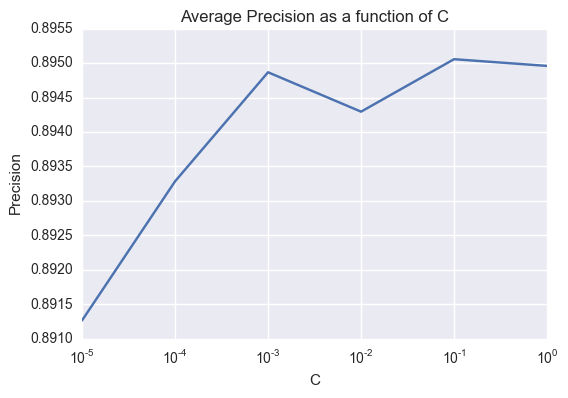

training logistic regression BIN_0
getting logistic regression predictions BIN_0
calculating logistic regression Performance on the train set: BIN_0
logistic regression train set auc: 0.903752417083
calculating logistic regression Performance on the test set: BIN_0
             precision    recall  f1-score   support

          0       0.82      0.63      0.71       508
          1       0.82      0.92      0.87       955

avg / total       0.82      0.82      0.82      1463

C=1e-05: 0.845406100004
C=0.0001: 0.851025306985
C=0.001: 0.859823075396
C=0.01: 0.863044623137
C=0.1: 0.865003281552
C=1.0: 0.86309644473


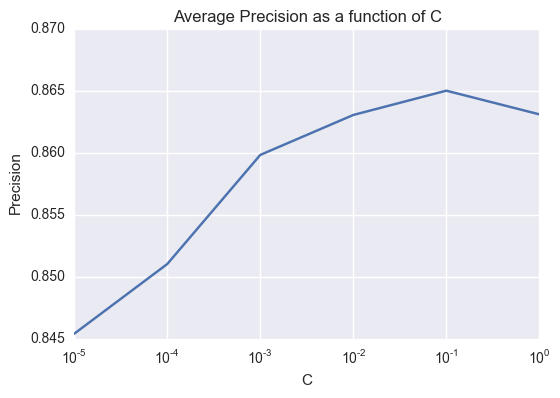

training logistic regression BIN_1
getting logistic regression predictions BIN_1
calculating logistic regression Performance on the train set: BIN_1
logistic regression train set auc: 0.869554770818
calculating logistic regression Performance on the test set: BIN_1
             precision    recall  f1-score   support

          0       0.83      0.85      0.84       860
          1       0.77      0.76      0.77       603

avg / total       0.81      0.81      0.81      1463

C=1e-05: 0.838154690803
C=0.0001: 0.846035502952
C=0.001: 0.861867845817
C=0.01: 0.877559442648
C=0.1: 0.876851631708
C=1.0: 0.873814960293


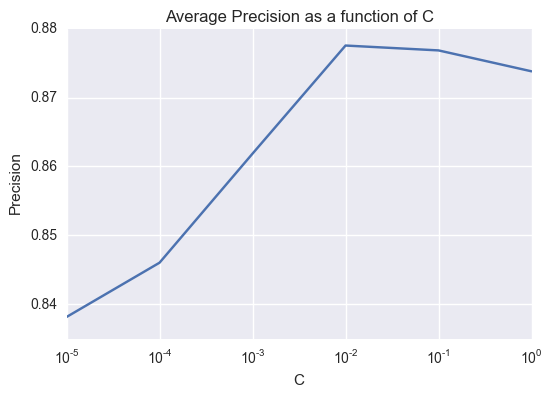

training logistic regression BIN_2
getting logistic regression predictions BIN_2
calculating logistic regression Performance on the train set: BIN_2
logistic regression train set auc: 0.878577568622
calculating logistic regression Performance on the test set: BIN_2
             precision    recall  f1-score   support

          0       0.87      0.96      0.91      1127
          1       0.80      0.53      0.64       336

avg / total       0.86      0.86      0.85      1463



In [33]:
for seperator in seperators:
    lr_train_len = train_len
    lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
    lr_ids = pp_data['id']

    lr_train_set = pp_data[:lr_train_len].copy()
    lr_test_set = pp_data[lr_train_len:].copy()

    lr_train_labels = lr_labels[:lr_train_len].copy()
    lr_test_labels = lr_labels[lr_train_len:].copy()

    lr_train_ids = lr_ids[:lr_train_len].copy()
    lr_test_ids = lr_ids[lr_train_len:].copy()

    lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_set = lr_train_set.append(lr_test_set, ignore_index=True)
    
    cv_scores = []
    space = np.logspace(-5,0, num=6)
    for c in space:
        res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='roc_auc')
        print "C=%s: %s" % (c, np.average(res))
        cv_scores.append(np.average(res))

    plot_cross_val(space, cv_scores, "C")
    lr_selceted_c = space[cv_scores.index(max(cv_scores))]
    
    print "training logistic regression", bin_names[seperators.index(seperator)]
    lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

    lr.fit(lr_train_set, lr_train_labels)
    print "getting logistic regression predictions", bin_names[seperators.index(seperator)]
    lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
    lr_predictions = lr.predict(lr_set)

    lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
    lr_test_predicted_probs = lr_predicted_probs[lr_train_len:]

    lr_train_predictions = lr_predictions[:lr_train_len]
    lr_test_predictions = lr_predictions[lr_train_len:]

    # attach LR predictions to the data as another feature
    pp_data['lr_prediction_%s' % bin_names[seperators.index(seperator)]] = lr_predictions.copy()
    pp_data['lr_prediction_proba_%s' % bin_names[seperators.index(seperator)]] = lr_predicted_probs.copy()

    print "calculating logistic regression Performance on the train set:", bin_names[seperators.index(seperator)]
    fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
    lr_auc = metrics.auc(fpr, tpr)
    print "logistic regression train set auc:", lr_auc
#     plotRoc(fpr, tpr, lr_auc)
    print "calculating logistic regression Performance on the test set:", bin_names[seperators.index(seperator)]
    print(metrics.classification_report(lr_test_labels, lr_test_predictions))
#     plotMetrics(lr_test_labels,lr_test_predicted_probs)


Deciding bin placements by logistic regressions binary predictions..
Got bin placements, 0 values determined by higher probability, 0 by probability sum, 8868 were definitive


ALL DATA:
[[1268  847  100    2]
 [ 341 1178  656   42]
 [ 110  695 1120  292]
 [  32  221  725 1239]]


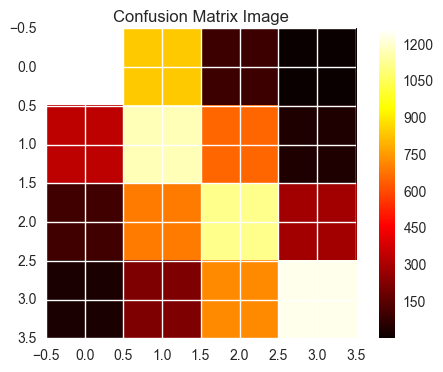

TEST SET ONLY:
[[386 213  24   0]
 [ 56 238 137  11]
 [ 13 108 152  45]
 [ 14  42 115 220]]


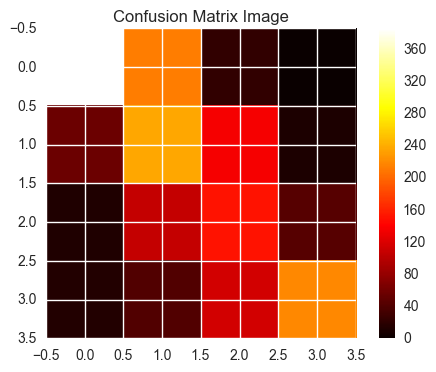

train score: 0.579903398497
train score: 0.536932619115
test score: 0.592819002579
test score: 0.561443066516


In [40]:
# unify predictions for bin classification
undef_1 = 0
undef_2 = 0

def decide_bin(row):
    global undef_1, undef_2
    preds = (row['lr_prediction_BIN_0'], row['lr_prediction_BIN_1'], row['lr_prediction_BIN_2'])
    pred_probas = (row['lr_prediction_proba_BIN_0'], row['lr_prediction_proba_BIN_1'], row['lr_prediction_proba_BIN_2'])

    if preds == (0, 0, 0):
        return 'BIN_0'
    elif preds == (1, 0, 0):
        return 'BIN_1'
    elif preds == (1, 1, 0):
        return 'BIN_2'
    elif preds == (1, 1, 1):
        return 'BIN_3'
    
    undef_1 += 1
    if preds[0] == 0 and pred_probas[0] < (1 - pred_probas[1]) and pred_probas[0] < (1 - pred_probas[2]):
        return 'BIN_0'

    if preds[2] == 1 and pred_probas[2] > (1 - pred_probas[1]) and pred_probas[2] > (1 - pred_probas[0]):
        return 'BIN_3'
    
    undef_2 += 1
    return 'BIN_%s' % int(round(sum(pred_probas)))

print "Deciding bin placements by logistic regressions binary predictions.."
bin_predictions = pp_data.apply(decide_bin, axis=1)
print "Got bin placements, %s values determined by higher probability, %s by probability sum, %s were definitive\n\n" % (undef_1, undef_2, pp_data.id.count() - undef_1 - undef_2)

print "========="
print "ALL DATA:"
print "========="
m = confusion_matrix(pp_data['labels'].values, bin_predictions.values)
print m
plotConfusion(m, 4)

print "=============="
print "TEST SET ONLY:"
print "=============="
m = confusion_matrix(pp_data['labels'][lr_train_len:].values, bin_predictions[lr_train_len:].values)
print m
plotConfusion(m, 4)

print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='macro')
print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='micro')
# print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='samples')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='macro')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='micro')
# print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='samples')

prediction_cols = ['lr_prediction_BIN_0', 'lr_prediction_BIN_1', 'lr_prediction_BIN_2', 'lr_prediction_proba_BIN_0', 'lr_prediction_proba_BIN_1', 'lr_prediction_proba_BIN_2']


4
0


IndexError: index 0 is out of bounds for axis 1 with size 0

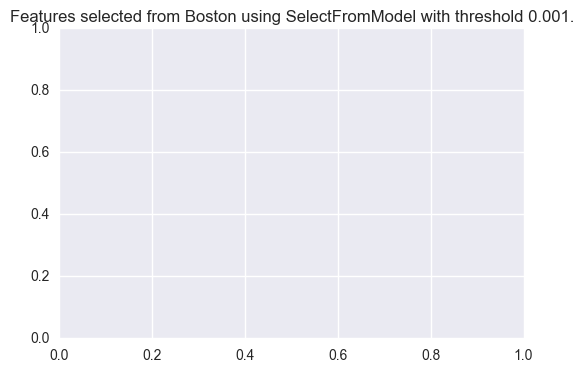

In [106]:
lr_train_len = train_len
lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= 50000 else 1)
# lr_labels = pp_data['labels'].apply(lambda x: int(x[-1]))
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_test_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_test_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_test_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)

# sfm = SelectFromModel(lm.LassoCV())
# sfm.fit(lr_train_set, lr_train_labels)
# n_features = sfm.transform(lr_train_set).shape[1]
# print n_features

# # Reset the threshold till the number of features equals two.
# # Note that the attribute can be set directly instead of repeatedly
# # fitting the metatransformer.
# while n_features > 2:
#     sfm.threshold += 0.001
#     X_transform = sfm.transform(lr_train_set)
#     n_features = X_transform.shape[1]
#     print n_features

# # Plot the selected two features from X.
# plt.title(
#     "Features selected from Boston using SelectFromModel with "
#     "threshold %0.3f." % sfm.threshold)
# feature1 = X_transform[:, 0]
# feature2 = X_transform[:, 1]
# plt.plot(feature1, feature2, 'r.')
# plt.xlabel("Feature number 1")
# plt.ylabel("Feature number 2")
# plt.ylim([np.min(feature2), np.max(feature2)])
# plt.show()

### Preprocessing

In [36]:
# lr_labelsfrom sklearn.metrics import confusion_matrixfrom sklearn.metrics import confusion_matrix = pp_data['likes']
lr_train_len = train_len
lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_test_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_test_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_test_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_set = lr_train_set.append(lr_test_set, ignore_index=True)

### Parameter optimization

C=1e-12: 0.866633983332
C=1e-11: 0.879851560951
C=1e-10: 0.883927165336
C=1e-09: 0.890033280944
C=1e-08: 0.888102944427
C=1e-07: 0.893298975005
C=1e-06: 0.902186580893
C=1e-05: 0.904886141368


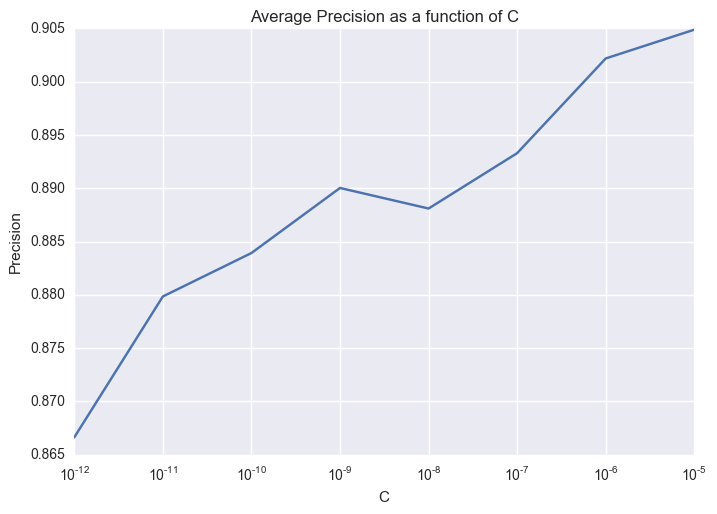

In [37]:
cv_scores = []
space = np.logspace(-10,-2, num=8)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

C=1e-10: 0.883927165336
C=2.15443469003e-10: 0.887292982014
C=4.64158883361e-10: 0.889880287287
C=1e-09: 0.890033280944
C=2.15443469003e-09: 0.889221849537
C=4.64158883361e-09: 0.888324973356
C=1e-08: 0.888102944265


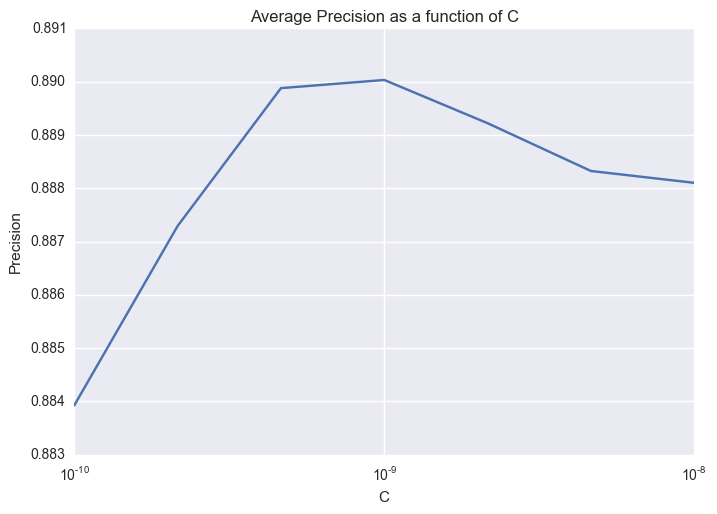

In [38]:
cv_scores = []
space = np.logspace(-10,-8, num=7)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

### LR running 

training logistic regression
getting logistic regression predictions
calculating logistic regression Performance on the train set:
logistic regression train set auc: 0.865343621882


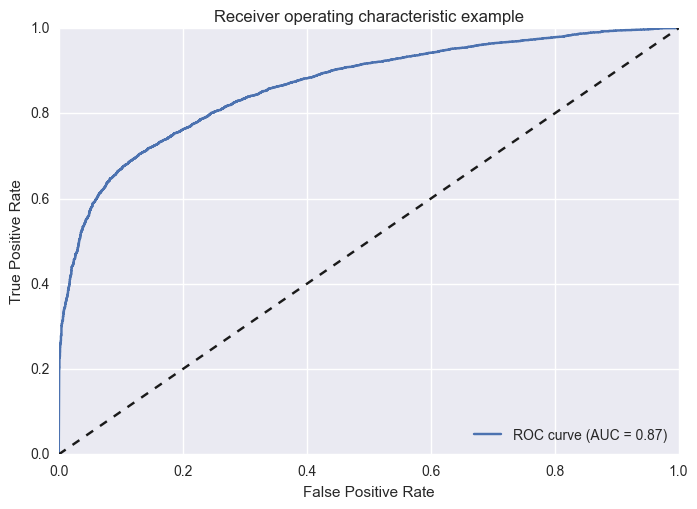

calculating logistic regression Performance on the test set:
             precision    recall  f1-score   support

          0       0.78      0.92      0.84      1506
          1       0.84      0.63      0.72      1059

avg / total       0.81      0.80      0.79      2565



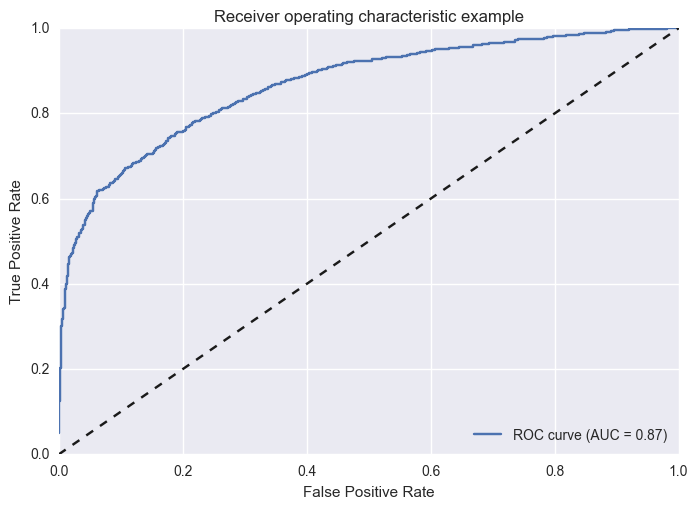

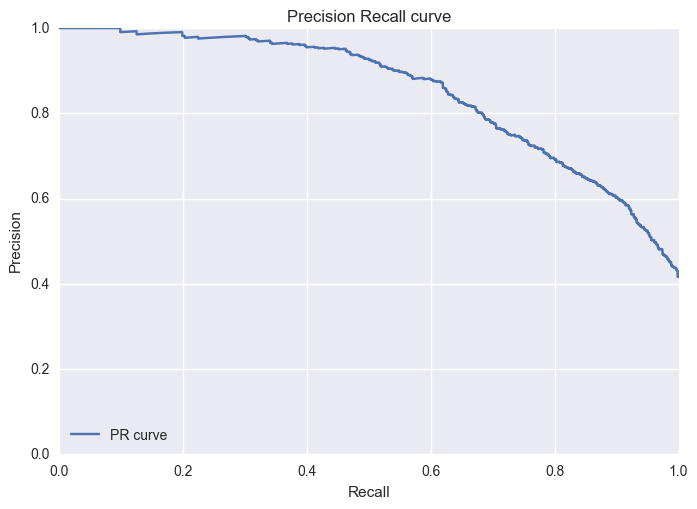

In [39]:
print "training logistic regression"
lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

lr.fit(lr_train_set, lr_train_labels)
print "getting logistic regression predictions"
lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
lr_predictions = lr.predict(lr_set)

lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
lr_test_predicted_probs = lr_predicted_probs[lr_train_len:]

lr_train_predictions = lr_predictions[:lr_train_len]
lr_test_predictions = lr_predictions[lr_train_len:]

# attach LR predictions to the data as another feature
pp_data['lr_prediction'] = lr_predictions.copy()

print "calculating logistic regression Performance on the train set:"
fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
lr_auc = metrics.auc(fpr, tpr)
print "logistic regression train set auc:", lr_auc
plotRoc(fpr, tpr, lr_auc)
print "calculating logistic regression Performance on the test set:"
print(metrics.classification_report(lr_test_labels, lr_test_predictions))
plotMetrics(lr_test_labels,lr_test_predicted_probs)

# pected = test_class.values
# oh_test_data= oh_test.drop('class',axis=1)
# predicted = logreg.predict(oh_test_data)
# predicted_probs = logreg.predict_proba(oh_test_data)

#add LR score as a new feature
# train_set['logistic_regression_prediction'] = lr_train_predictions
# test_set['logistic_regression_prediction'] = lr_test_predictions

# SVM

## Binary separetors

### Preprocessing

In [17]:
unscaled_svm_pp_data = pp_data.copy()
svm_train_len = train_len
svm_test_len = int(len(pp_data['id'])) - train_len
# svm_pp_data.drop(categorical_variables, 1, inplace=True)


svm_labels = unscaled_svm_pp_data['labels'].apply(lambda x: 0 if (x == 'BIN_0' or x == 'BIN_1') else 1)
svm_multi_labels = unscaled_svm_pp_data['labels'].map({'BIN_0':0, 'BIN_1':1, 'BIN_2':2, 'BIN_3':3})
svm_ids = unscaled_svm_pp_data['id']

unscaled_svm_pp_data.drop(['likes', 'labels', 'id'], 1, inplace=True)
svm_pp_data = preprocessing.minmax_scale(unscaled_svm_pp_data)


svm_train_set = svm_pp_data[:svm_train_len].copy()
svm_test_set = svm_pp_data[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_labels = svm_labels[:svm_train_len].copy()
svm_test_labels = svm_labels[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_multi_labels = svm_multi_labels[:svm_train_len].copy()
svm_test_multi_labels = svm_multi_labels[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_ids = svm_ids[:svm_train_len].copy()
svm_test_ids = svm_ids[svm_train_len:svm_train_len+svm_test_len].copy()

In [21]:
svm_set = np.append(svm_train_set,svm_test_set, axis=0)

pca = PCA()
pca.fit(svm_train_set)
pca_svm_set = pca.transform(svm_set)
pca_svm_tarin_set = pca_svm_set[:train_len]
pca_svm_test_set = pca_svm_set[train_len:]

In [22]:
svm_model = svm.SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(pca_svm_tarin_set, svm_train_labels)

svm_train_pred = svm_model.predict(pca_svm_tarin_set)
train_acc = metrics.accuracy_score(svm_train_labels, svm_train_pred)

svm_test_pred = svm_model.predict(pca_svm_test_set)
test_acc = metrics.accuracy_score(svm_test_labels, svm_test_pred)


print "TRAIN ACCURACY:  " + str(train_acc)
print "=============="
print "TEST ACCURACY:  " + str(test_acc)
print "============="

TRAIN ACCURACY:  0.840564097542
TEST ACCURACY:  0.814336075206


In [27]:
svm_set = np.append(svm_train_set,svm_test_set, axis=0)

pca = PCA(80)
pca.fit(svm_train_set)
pca_svm_set = pca.transform(svm_set)
pca_svm_tarin_set = pca_svm_set[:train_len]
pca_svm_test_set = pca_svm_set[train_len:]

In [28]:
svm_model = svm.SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(pca_svm_tarin_set, svm_train_labels)

svm_train_pred = svm_model.predict(pca_svm_tarin_set)
train_acc = metrics.accuracy_score(svm_train_labels, svm_train_pred)

svm_test_pred = svm_model.predict(pca_svm_test_set)
test_acc = metrics.accuracy_score(svm_test_labels, svm_test_pred)


print "TRAIN ACCURACY:  " + str(train_acc)
print "=============="
print "TEST ACCURACY:  " + str(test_acc)
print "============="

TRAIN ACCURACY:  0.832239741455
TEST ACCURACY:  0.801801801802


### Parameter optimization 

In [ ]:
cv_scores = []
cs = []
for c in range(-12,-3):#-2,2):
    res = cross_val_score(svm.SVC(C=10**c), svm_train_set, svm_train_labels, cv=3, scoring='roc_auc')
    print "C=%s: %s" % (10**c, np.average(res))
    cs.append(10**c)
    cv_scores.append(np.average(res))
    
plot_cross_val(cs, cv_scores, "C")
svm_selceted_c = cv_scores[cv_scores.index(max(cv_scores))]

In [ ]:
cv_scores = []
cs = []
for c in range(-15,-3):
    res = cross_val_score(svm.SVC(C=10**c), svm_train_set, svm_train_labels,scoring='average_precision')
    print "C=%s: %s" % (10**c, np.average(res))
    cs.append(10**c)
    cv_scores.append(np.average(res))
    
plot_cross_val(cs, cv_scores, "C")
svm_selceted_c = cv_scores[cv_scores.index(max(cv_scores))]

#TODO: add cv for gemma

In [ ]:
from sklearn.model_selection import GridSearchCV
print("Fitting the classifier to the training set")
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid)
clf = clf.fit(svm_train_set, svm_train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

### SVM run

In [ ]:
# svm_selceted_c = 16.681005372
# svm_selceted_gamma = 0.0316227766017

# svm_model = svm.SVC(probability=True, C=svm_selceted_c)#, gamma=svm_selceted_gamma)

In [19]:
svm_model = svm.SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(svm_train_set, svm_train_labels)

svm_train_pred = svm_model.predict(svm_train_set)
train_acc = metrics.accuracy_score(svm_train_labels, svm_train_pred)

svm_test_pred = svm_model.predict(svm_test_set)
test_acc = metrics.accuracy_score(svm_test_labels, svm_test_pred)


print "TRAIN ACCURACY:  " + str(train_acc)
print "=============="
print "TEST ACCURACY:  " + str(test_acc)
print "============="


TRAIN ACCURACY:  0.838605425521
TEST ACCURACY:  0.805718762241


calculating SVM Performance on the train set:
svm train set auc: 0.917719521577


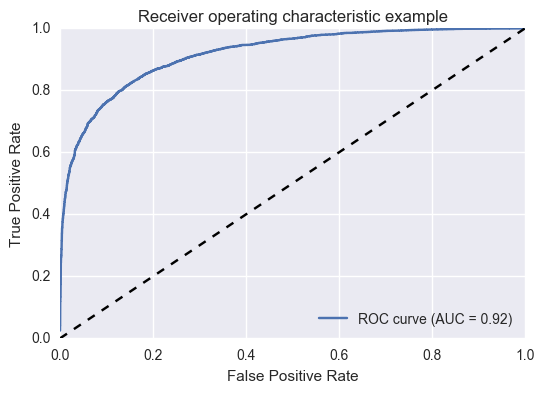

calculating SVM Performance on the test set:
svm test set auc: 0.867541870373


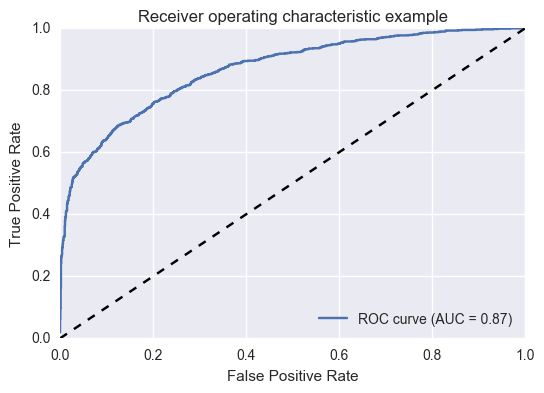

             precision    recall  f1-score   support

          0       0.82      0.86      0.84      1586
          1       0.75      0.70      0.72       967

avg / total       0.79      0.80      0.79      2553



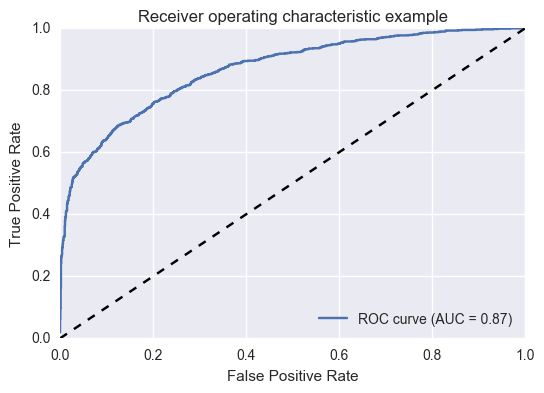

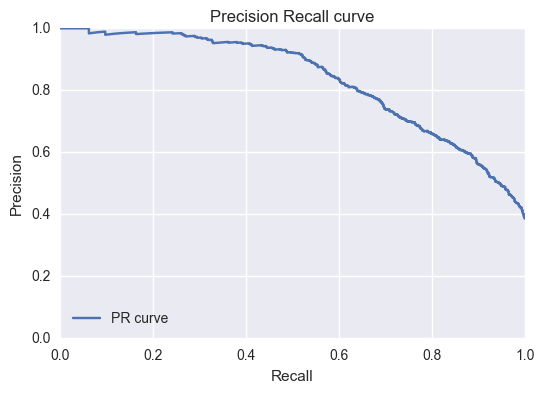

In [34]:
svm_model = svm.SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


svm_model.fit(svm_train_set, svm_train_labels)

svm_train_prediction = svm_model.predict(svm_train_set)
svm_test_prediction = svm_model.predict(svm_test_set)

svm_train_predicted_probs = svm_model.predict_proba(svm_train_set)[:, 1]
svm_test_predicted_probs = svm_model.predict_proba(svm_test_set)[:, 1]

print "calculating SVM Performance on the train set:"
fpr, tpr, thresholds = metrics.roc_curve(svm_train_labels, svm_train_predicted_probs)
svm_train_auc = metrics.auc(fpr, tpr)
print "svm train set auc:", svm_train_auc
plotRoc(fpr, tpr, svm_train_auc)

print "calculating SVM Performance on the test set:"
fpr, tpr, thresholds = metrics.roc_curve(svm_test_labels, svm_test_predicted_probs)
svm_test_auc = metrics.auc(fpr, tpr)
print "svm test set auc:", svm_test_auc
plotRoc(fpr, tpr, svm_test_auc)

print(metrics.classification_report(svm_test_labels, svm_test_prediction))
plotMetrics(svm_test_labels,svm_test_predicted_probs)

In [ ]:
from sklearn.model_selection import GridSearchCV
print("Fitting the classifier to the training set")
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid)
clf = clf.fit(svm_train_set, svm_train_multi_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

## Multi Calss SVM

### Parameter optimization 

In [100]:
from sklearn.model_selection import GridSearchCV
print("Fitting the classifier to the training set")
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['rbf', 'linear']}
clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid)
clf = clf.fit(svm_train_set, svm_train_multi_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### SVM run

MULTI-CLASS TRAIN ACCURACY:  0.647634903535
[[1925  366  101    5]
 [ 624 1149  581   45]
 [ 207  580 1545  326]
 [  42  109  612 1994]]


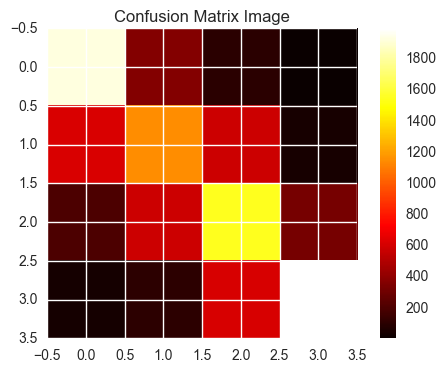

MULTI-CLASS TEST ACCURACY:  0.555424990208
[[556 201  36   1]
 [252 346 184  10]
 [ 62 179 230  62]
 [ 13  30 105 286]]


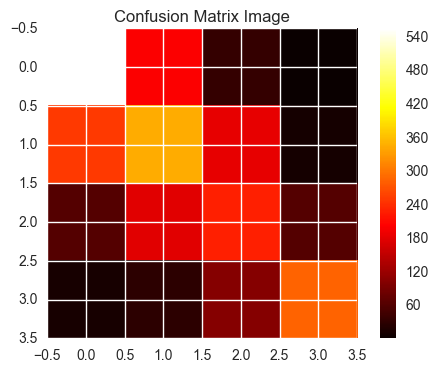

In [46]:
# svm_model = svm.SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
#   decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
#   max_iter=-1, probability=False, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)

# svm_model.fit(svm_train_set, svm_train_multi_labels)

# svm_train_pred = svm_model.predict(svm_train_set)
# train_acc = metrics.accuracy_score(svm_train_multi_labels, svm_train_pred)

# svm_test_pred = svm_model.predict(svm_test_set)
# test_acc = metrics.accuracy_score(svm_test_multi_labels, svm_test_pred)

print "MULTI-CLASS TRAIN ACCURACY:  " + str(train_acc)
print "=========================="
m = confusion_matrix(svm_train_multi_labels, svm_train_pred)
print m
plotConfusion(m, 4)

print "MULTI-CLASS TEST ACCURACY:  " + str(test_acc)
print "========================="

m = confusion_matrix(svm_test_multi_labels, svm_test_pred)
print m
plotConfusion(m, 4)

## KNN

test accuracy for k = 2:  0.414023
test accuracy for k = 6:  0.437524
test accuracy for k = 10:  0.426949
test accuracy for k = 14:  0.414414
test accuracy for k = 18:  0.412848
test accuracy for k = 22:  0.403055
test accuracy for k = 26:  0.419506
test accuracy for k = 30:  0.421073
test accuracy for k = 34:  0.425774
test accuracy for k = 38:  0.418331
test accuracy for k = 42:  0.426949
test accuracy for k = 46:  0.427340
test accuracy for k = 50:  0.428515
test accuracy for k = 54:  0.428124
test accuracy for k = 58:  0.426557
test accuracy for k = 62:  0.423423
test accuracy for k = 66:  0.427340
test accuracy for k = 70:  0.426165


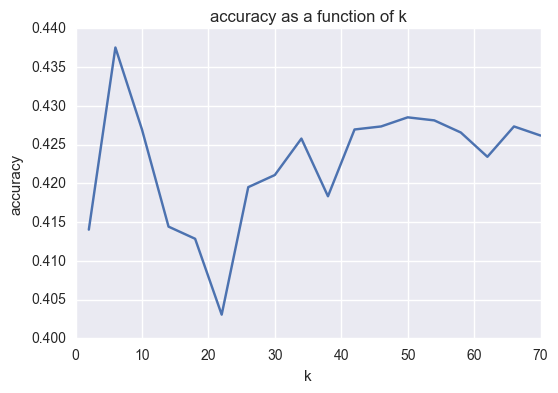

In [23]:
knn_tarin_set = svm_train_set.copy()
knn_test_set = svm_test_set.copy()

knn_train_labels = svm_train_multi_labels.copy()
knn_test_labels = svm_test_multi_labels.copy()

k_range = [k for k in range(2,71,4)]
test_accuracies = []

for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(knn_tarin_set, knn_train_labels)
    knn_test_pred = knn.predict(knn_test_set)
    test_acc = metrics.accuracy_score(knn_test_labels, knn_test_pred)
    print "test accuracy for k = %d:  %f" %(k, test_acc)
    test_accuracies.append(test_acc)

plot_results(k_range, test_accuracies, "accuracy", "k")

test accuracy for k = 2:  0.422640
test accuracy for k = 6:  0.434391
test accuracy for k = 10:  0.441833
test accuracy for k = 14:  0.434391
test accuracy for k = 18:  0.446533
test accuracy for k = 22:  0.450059
test accuracy for k = 26:  0.436349
test accuracy for k = 30:  0.444575
test accuracy for k = 34:  0.441833
test accuracy for k = 38:  0.441833
test accuracy for k = 42:  0.442617
test accuracy for k = 46:  0.436741
test accuracy for k = 50:  0.442617
test accuracy for k = 54:  0.443400
test accuracy for k = 58:  0.441441
test accuracy for k = 62:  0.433999
test accuracy for k = 66:  0.439091
test accuracy for k = 70:  0.433216


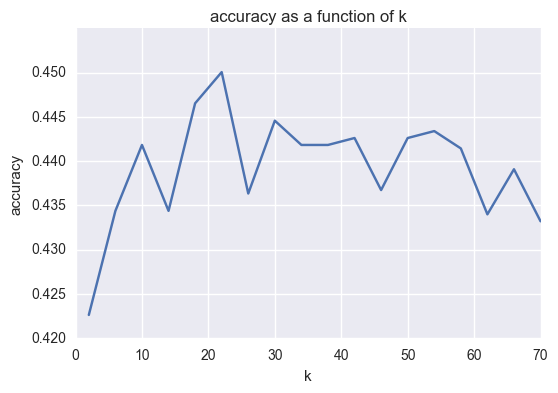

In [20]:
from sklearn.decomposition import PCA

knn_tarin_set = svm_train_set.copy()
knn_test_set = svm_test_set.copy()
knn_train_labels = svm_train_multi_labels.copy()
knn_test_labels = svm_test_multi_labels.copy()

knn_set = np.append(knn_tarin_set,knn_test_set, axis=0)

pca = PCA()
pca.fit(knn_tarin_set)
pca_knn_set = pca.transform(knn_set)
pca_knn_tarin_set = pca_knn_set[:train_len]
pca_knn_test_set = pca_knn_set[train_len:]


knn_train_labels = svm_train_multi_labels.copy()
knn_test_labels = svm_test_multi_labels.copy()

k_range = [k for k in range(2,71,4)]
test_accuracies = []

for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(pca_knn_tarin_set, knn_train_labels)
    knn_test_pred = knn.predict(pca_knn_test_set)
    test_acc = metrics.accuracy_score(knn_test_labels, knn_test_pred)
    print "test accuracy for k = %d:  %f" %(k, test_acc)
    test_accuracies.append(test_acc)

plot_results(k_range, test_accuracies, "accuracy", "k")

test accuracy for k = 2:  0.414023
test accuracy for k = 3:  0.422248
test accuracy for k = 4:  0.429299
test accuracy for k = 5:  0.441441
test accuracy for k = 6:  0.437524
test accuracy for k = 7:  0.425382
test accuracy for k = 8:  0.415590
test accuracy for k = 9:  0.426557


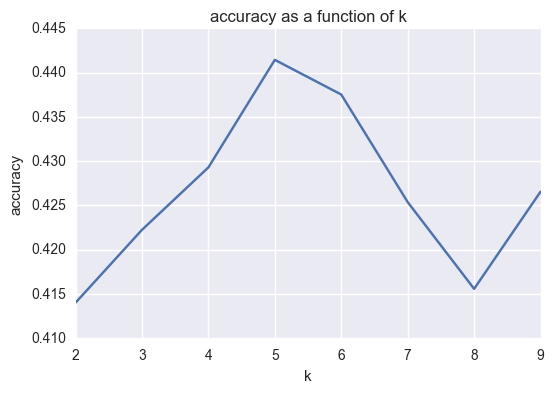

In [24]:
k_range = [k for k in range(2,10)]
test_accuracies = []

for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(knn_tarin_set, knn_train_labels)
    knn_test_pred = knn.predict(knn_test_set)
    test_acc = metrics.accuracy_score(knn_test_labels, knn_test_pred)
    print "test accuracy for k = %d:  %f" %(k, test_acc)
    test_accuracies.append(test_acc)

plot_results(k_range, test_accuracies, "accuracy", "k")

## Random Forest

### Preprocessing

In [100]:
rf_train_len = train_len
rf_labels = pp_data['labels']
rf_ids = pp_data['id']

rf_train_set = pp_data[:rf_train_len].copy()
rf_test_set = pp_data[rf_train_len:].copy()


rf_train_ids = rf_ids[:rf_train_len].copy()
rf_test_ids = rf_ids[rf_train_len:].copy()

rf_train_labels = rf_labels[:rf_train_len].copy()
rf_test_labels = rf_labels[rf_train_len:].copy()

rf_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
rf_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)



### Parameter optimization

Feature ranking - Top 10:
1. feature 81 (talking_about_count)
   score: 0.076324
2. feature 53 (self_feed_avg_likes)
   score: 0.047434
3. feature 62 (self_feed_max_likes)
   score: 0.040070
4. feature 16 (photo_max_like)
   score: 0.037247
5. feature 74 (self_feed_std_likes)
   score: 0.035431
6. feature 11 (photo_avg_likes_per_photo)
   score: 0.033185
7. feature 26 (total_photos)
   score: 0.031137
8. feature 94 (posting_freq)
   score: 0.027220
9. feature 27 (photo_number_of_days_between_first_and_last_photos)
   score: 0.026295
10. feature 64 (self_feed_min_likes)
   score: 0.025644
11. feature 52 (self_feed_avg_comments)
   score: 0.025380
12. feature 24 (photo_number_of_photos_in_profile_albums)
   score: 0.022719
13. feature 61 (self_feed_max_comments)
   score: 0.022680
14. feature 57 (self_feed_number_of_days_between_first_and_last_posts)
   score: 0.022167
15. feature 73 (self_feed_std_comments)
   score: 0.020674
16. feature 76 (self_feed_max_shares)
   score: 0.019648
17. 

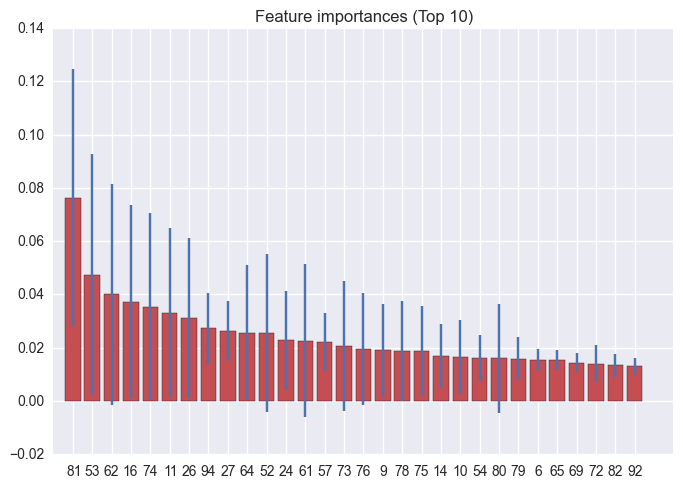

In [101]:
forest = RandomForestClassifier(n_estimators=250, max_depth=15)
forest.fit(rf_train_set.values, rf_train_labels.values)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking - Top 10:")
for f in range(100):
    print("%d. feature %d (%s)\n   score: %f" % (f + 1, indices[f], list(rf_train_set)[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plot_idxs = indices[:30]
plt.figure()
plt.title("Feature importances (Top 10)")
plt.bar(range(30), importances[plot_idxs],
       color="r", yerr=std[plot_idxs], align="center")
plt.xticks(range(30), plot_idxs)
plt.xlim([-1, 31])
plt.show()

In [93]:
importances_thresholds = [0, 0.01] #[0, 0.01, 0.02, 0.03, 0.04]
max_depths = [15, None] #[10, 20, 30, None]
min_samples_leaf = [1] #[1, 3, 5]

filtered_by_thresholds = []
for t in importances_thresholds:
    columns = []
    for f in range(rf_train_set.shape[1]):
        if importances[indices[f]] >= t:
            columns.append(list(rf_train_set)[indices[f]])
    filtered_by_thresholds.append(columns)

params = []
score_summary = []
print "(threshold, depth, min_samples) -> average precision score"
for i in range(len(filtered_by_thresholds)):
    for d in max_depths:
        for l in min_samples_leaf:
            cols = filtered_by_thresholds[i]
            forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=d, min_samples_leaf=l)
            forest.fit(rf_train_set, rf_train_labels)
            temp_predictions = forest.predict(rf_test_set)
            res = metrics.precision_score(rf_test_labels, temp_predictions, average='macro')
            score_summary.append(res)
            params.append((importances_thresholds[i], d, l))
            print "%s -> %s" % (params[-1], score_summary[-1])
    
max_idx = np.argmax(score_summary)
best_threshold = params[max_idx][0]
best_max_depth = params[max_idx][1]
best_min_leaf = params[max_idx][2]

# Print best hyper parameters
print "RF best parameters:"
print "max_depth = ", best_max_depth
print "importance_threshold = ", best_threshold
print "min_samples_leaf = ", best_min_leaf

(threshold, depth, min_samples) -> average precision score
(0, 15, 1) -> 0.628949434362
(0, None, 1) -> 0.622307083975
(0.01, 15, 1) -> 0.628949434362
(0.01, None, 1) -> 0.622307083975
RF best parameters:
max_depth =  15
importance_threshold =  0
min_samples_leaf =  1


### RF running

Random Forest test precision: 0.623194319339
[[596 185  13   0]
 [226 379 178   9]
 [ 46 141 275  71]
 [  5  29  87 313]]


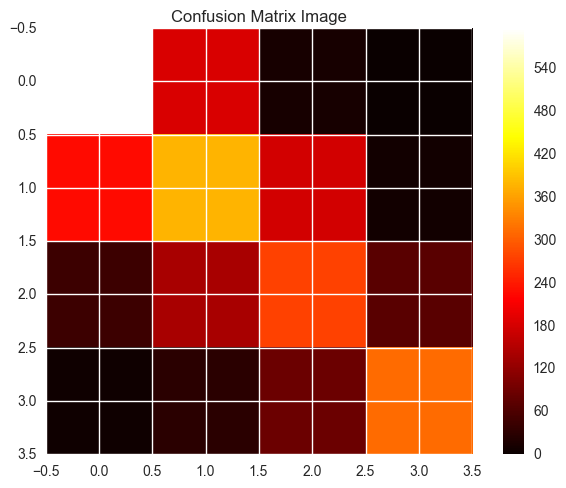

In [94]:
fc = filtered_by_thresholds[importances_thresholds.index(best_threshold)]
forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_leaf, oob_score=True)
forest.fit(rf_train_set[fc].values, rf_train_labels)
rf_train_predicted_probs = forest.predict_proba(rf_train_set[fc])
rf_test_predicted_probs = forest.predict_proba(rf_test_set[fc])
rf_test_predictions = forest.predict(rf_test_set[fc])
res = metrics.precision_score(rf_test_labels, rf_test_predictions, average='macro')
print "Random Forest test precision:", res

cm_rf_labels = rf_test_labels.apply(lambda x: x[-1])
cm_rf_predictions = [a[-1] for a in rf_test_predictions.tolist()]
m = confusion_matrix(cm_rf_labels.values, cm_rf_predictions)
print m
plotConfusion(m, bin_num)

## Linear Regression

In [153]:
linr_pp_data = pp_data.copy()
linr_train_len = train_len
linr_test_len = int(len(pp_data['id'])) - train_len

linr_labels = linr_pp_data['likes'].apply(lambda x: np.log(x) if x > 0 else 0)
linr_ids = linr_pp_data['id']


######
linr_bin_labels = linr_pp_data['labels'].copy()
linr_train_set_bin_labels = linr_bin_labels[:train_len]
linr_test_set_bin_labels = linr_bin_labels[train_len:]
linr_likes = linr_pp_data['likes'].copy()
#####

linr_pp_data.drop(['likes', 'labels', 'id'], 1, inplace=True)
# features = pp_data.columns.get_values().tolist()
# countries = [a for a in features if 'country' in a]
# categories = [a for a in features if 'category' in a]
# continents = [a for a in features if 'continent' in a]
# linr_pp_data.drop(countries + categories + continents, 1, inplace=True)

linr_data = preprocessing.minmax_scale(linr_pp_data)

linr_train_set = linr_data[:linr_train_len].copy()
linr_test_set = linr_data[linr_train_len:linr_train_len+linr_test_len].copy()

linr_train_labels = linr_labels[:linr_train_len].copy()
linr_test_labels = linr_labels[linr_train_len:linr_train_len+linr_test_len].copy()

linr_train_ids = linr_ids[:linr_train_len].copy()
linr_test_ids = linr_ids[linr_train_len:linr_train_len+linr_test_len].copy()

In [152]:
linr = sklearn.linear_model.LinearRegression()
linr.fit(linr_train_set, linr_train_labels)

train_predictions = linr.predict(linr_train_set)
test_predictions = linr.predict(linr_test_set)

# The coefficients
print 'Coefficients: '
coefs = linr.coef_
features = linr_pp_data.columns.get_values().tolist()
lst = []
for i in range(len(features)):
    lst.append((features[i], coefs[i]))
feat_coef = sorted(lst, key=lambda x: x[1])
feat_coef_str = ""
for a in feat_coef:
    feat_coef_str += a[0] + ": " + str(a[1]) +", "
print feat_coef_str[:-2]
# The mean squared error
print "\n\nMean squared error: %.2f" %(np.mean((linr.predict(linr_train_set) - linr_train_labels) ** 2))
# Explained variance score: 1 is perfect prediction
print 'training variance score: %.2f' %(linr.score(linr_train_set, linr_train_labels))
print 'test variance score: %.2f' %(linr.score(linr_test_set, linr_test_labels))

Coefficients: 
photo_number_of_albums: -336677949387.0, feed_std_comments: -25.1648466587, feed_avg_shares: -12.3910419941, self_feed_avg_shares: -10.6393871307, self_feed_avg_likes: -8.40411567688, self_feed_max_likes: -7.23468399048, self_feed_avg_likes_per_comment: -6.56322574615, feed_std_likes: -5.21355569363, self_feed_max_shares: -5.0647649765, self_feed_min_comments: -4.51196300983, feed_min_shares: -4.23795443773, feed_avg_with_tagged_per_post: -3.55512952805, self_feed_avg_people_tagged_per_post_with_more_than_zero: -3.30021381378, photo_max_like: -2.86806502622, photo_upload_freq: -2.64226150513, feed_min_comments: -2.53086686134, self_feed_post_max_people_tagged: -2.21335601807, photo_number_of_different_months_for_photos: -2.1467028383, feed_avg_likes_per_comment: -2.13084311309, photo_count_has_name: -2.07739239702, feed_avg_people_tagged_per_post: -1.96699502113, self_feed_number_of_different_months_for_post: -1.94442749023, feed_min_likes: -1.62671005726, name_num_of_wo

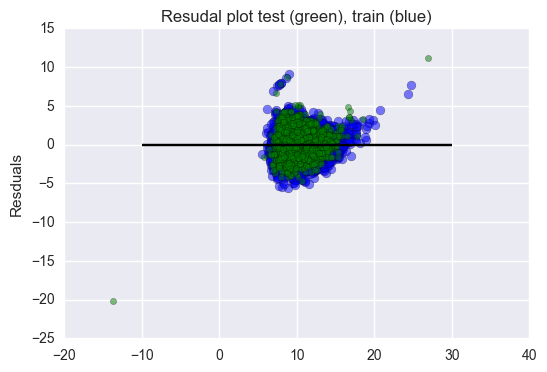

In [135]:
plt.scatter(train_predictions, train_predictions -  linr_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(test_predictions, test_predictions -  linr_test_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=-10, xmax=30)
plt.title('Resudal plot test (green), train (blue)')
plt.ylabel('Resduals')
plt.show()

0.55577318578
[[1580  669  142    6]
 [ 701  988  642   68]
 [ 244  732 1155  527]
 [  28  164  613 1952]]


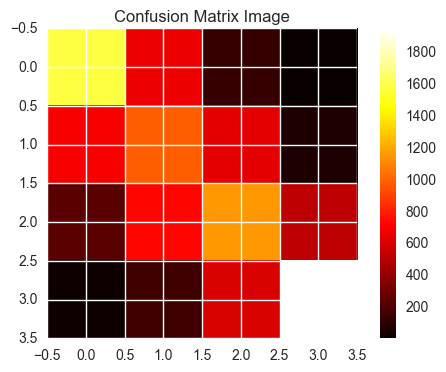

In [136]:
bin_num = 4
exp_pred = np.exp(train_predictions)
pred_bins = binning(exp_pred, 4)

err = 0
for i in range(len(linr_train_set_bin_labels)):
    if linr_train_set_bin_labels[i] != pred_bins[i]:
        err+=1
print ((len(linr_train_set_bin_labels) - err) * 1.0) / len(linr_train_set_bin_labels)

m = confusion_matrix(linr_train_set_bin_labels.values, pred_bins)
print m
plotConfusion(m, bin_num)

[[430 252  98  14]
 [165 272 267  88]
 [ 37  99 214 183]
 [  7  15  60 352]]


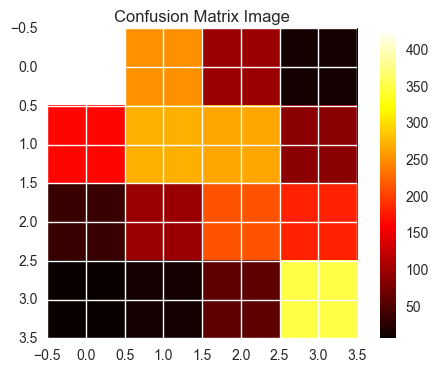

In [121]:
bin_num = 4
test_exp_pred = np.exp(test_predictions)
test_pred_bins = binning(test_exp_pred, 4)

# err = 0
# for i in range(len(linr_train_set_bin_labels)):
#     if linr_train_set_bin_labels[i] != pred_bins[i]:
#         err+=1
# print ((len(linr_train_set_bin_labels) - err) * 1.0) / len(linr_train_set_bin_labels)

m = confusion_matrix(linr_test_set_bin_labels.values, test_pred_bins)
print m
plotConfusion(m, bin_num)

The train accuracy fot 5 bins: 0.492312
[[1301  563  157   21    1]
 [ 511  749  570  202   10]
 [ 175  491  721  564   91]
 [  49  195  488  813  497]
 [   7   44  107  441 1443]]


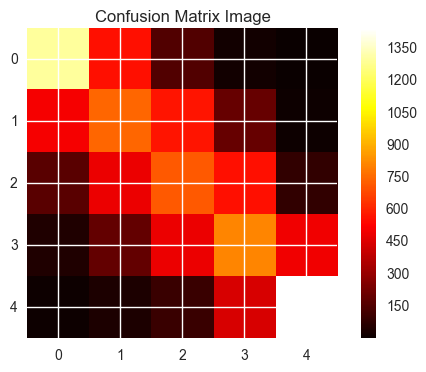

In [122]:
bin_num = 5
exp_pred = np.exp(train_predictions)
pred_bins = binning(exp_pred, bin_num)


linr_train_set_bin_labels = binning(linr_likes[:train_len], bin_num)

err = 0
for i in range(len(linr_train_set_bin_labels)):
    if linr_train_set_5bin_labels[i] != pred_bins[i]:
        err+=1
print "The train accuracy fot %d bins: %f" %(bin_num,((len(linr_train_set_bin_labels) - err) * 1.0) / len(linr_train_set_5bin_labels))

m = confusion_matrix(linr_train_set_5bin_labels.values, pred_bins)
print m
plotConfusion(m, bin_num)

## Lasso Regression

In [250]:
logr_pp_data = pp_data.copy()

logr_labels = logr_pp_data['likes'].apply(lambda x: np.log(x) if x > 0 else 0)
logr_ids = logr_pp_data['id']


######
logr_bin_labels = logr_pp_data['labels'].copy()
logr_train_set_bin_labels = logr_bin_labels[:train_len]
logr_test_set_bin_labels = logr_bin_labels[train_len:]
logr_likes = logr_pp_data['likes'].copy()
#####

logr_pp_data.drop(['likes', 'labels', 'id'], 1, inplace=True)
# features = pp_data.columns.get_values().tolist()
# countries = [a for a in features if 'country' in a]
# categories = [a for a in features if 'category' in a]
# continents = [a for a in features if 'continent' in a]
# linr_pp_data.drop(countries + categories + continents, 1, inplace=True)

logr_data = preprocessing.minmax_scale(logr_pp_data)

logr_train_set = logr_data[:train_len].copy()
logr_test_set = logr_data[train_len:].copy()

logr_train_labels = logr_labels[:train_len].copy()
logr_test_labels = logr_labels[train_len:].copy()

logr_train_ids = logr_ids[:train_len].copy()
logr_test_ids = logr_ids[train_len:].copy()

Computing regularization path using the coordinate descent lasso...


(0.32909410483893076,
 3.3290941048389309,
 0.73230256712004993,
 16.107596035773806)

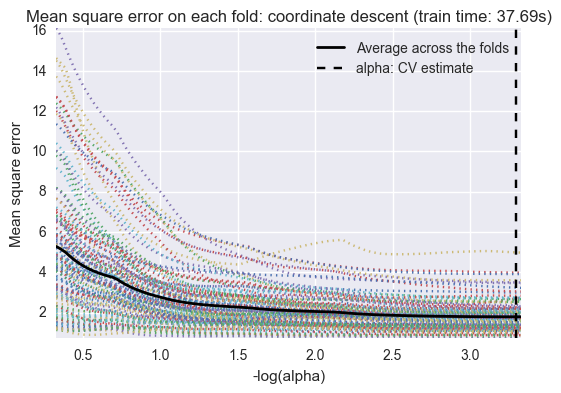

In [254]:
import time
# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
# Display results
logr = lm.LassoCV(cv=120)
logr.fit(logr_train_set, logr_train_labels)
m_log_alphas = -np.log10(logr.alphas_)
t_lasso_cv = time.time() - t1


plt.figure()
# ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, logr.mse_path_, ':')
plt.plot(m_log_alphas, logr.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(logr.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
# plt.ylim(ymin, ymax)

In [255]:
print "getting lasso regression predictions"
logr_train_predictions = logr.predict(logr_train_set)
logr_test_predictions = logr.predict(logr_test_set)


print "calculating lasso regression Performance on the test set:"
print "train %f" %logr.score(logr_train_set, logr_train_labels.values)
print "test %f" %logr.score(logr_test_set, logr_test_labels.values)

getting lasso regression predictions
calculating lasso regression Performance on the test set:
train 0.672995
test 0.562362


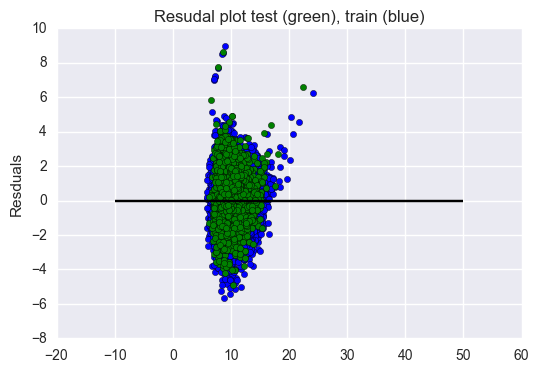

In [256]:
#TODO: add scatter plot predicted vs actual

plt.scatter(logr_train_predictions, logr_train_predictions -  logr_train_labels, c='b')#, s=40, alpha=0.6)
plt.scatter(logr_test_predictions, logr_test_predictions -  logr_test_labels, c='g')#, alpha=0.6)
plt.hlines(y=0, xmin=-10, xmax=50)
plt.title('Resudal plot test (green), train (blue)')
plt.ylabel('Resduals')
plt.show()

0.58270492606
[[1692  608   95    2]
 [ 652 1080  614   53]
 [ 182  708 1224  544]
 [  27  157  619 1954]]


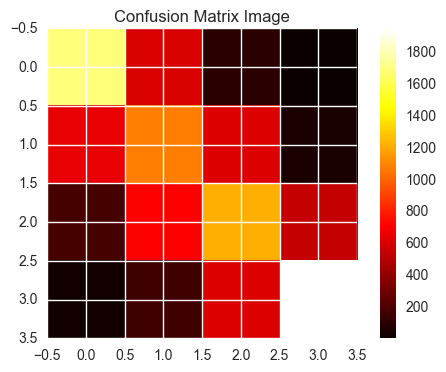

In [257]:
bin_num = 4
exp_pred = np.exp(logr_train_predictions)
pred_bins = binning(exp_pred, 4)

err = 0
for i in range(len(logr_train_set_bin_labels)):
    if logr_train_set_bin_labels[i] != pred_bins[i]:
        err+=1
print ((len(logr_train_set_bin_labels) - err) * 1.0) / len(logr_train_set_bin_labels)

m = confusion_matrix(logr_train_set_bin_labels.values, pred_bins)
print m
plotConfusion(m, bin_num)

[[429 250 104  11]
 [167 269 264  92]
 [ 37 106 200 190]
 [  6  13  70 345]]


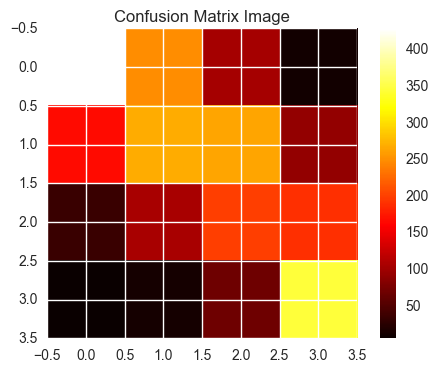

In [258]:
bin_num = 4
exp_pred = np.exp(logr_test_predictions)
pred_bins = binning(exp_pred, 4)

# err = 0
# for i in range(len(logr_test_set_bin_labels)):
#     if logr_test_set_bin_labels[i] != pred_bins[i]:
#         err+=1
# print ((len(logr_test_set_bin_labels) - err) * 1.0) / len(logr_test_set_bin_labels)

m = confusion_matrix(logr_test_set_bin_labels.values, pred_bins)
print m
plotConfusion(m, bin_num)